In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Tips


+ 控制绘图大小
  + `plotly.express`里，可以直接控制绘制的图形大小.
  ```python
  fig = px.scatter(df, x="total_bill", y="tip", facet_col="sex", width=800, height=400)
  ```
  + 使用`plotly.graph_object`时，必须要通过 update_layout 实现
  ```python
    fig.update_layout(
        autosize=False,
        width=500,
        height=500,
        # 设置一下 页面白边
        margin=dict(l=30, r=30, t=30, b=30)
    )
  ```


+ 使用`color`来进行分组时，比如`fig = px.scatter(data_frame=X_y, x='x1', y='x2',color='group', color_discrete_sequence=["red", "magenta", "blue"])`，根据其中用于分组的`group`字段类型，返回的结果是不一样的：
  + 如果`group`字段是一个连续字段，那么返回的`fig`里，就只有 1 条 trace
  + 如果`group`字段是一个离散字段(str之类的)，那么返回的`fig`里，就会有多条 trace，数量等于`group`的分组数。  

+ [手动设置散点图或者线图的颜色](https://stackoverflow.com/questions/63413928/plotly-how-to-manually-set-the-color-of-points-in-plotly-express-scatter-plots)

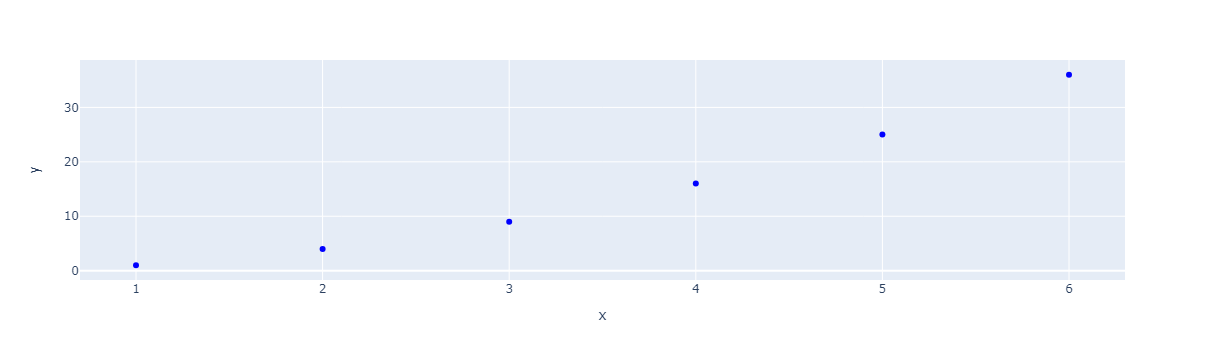

In [6]:
# 通过 color_discrete_sequence=['color'] 方式设置
scatter = px.scatter(x=[1,2,3,4,5,6], y=[1,4,9,16,25,36], color_discrete_sequence=['blue'])
scatter.show(width=200, height=400)

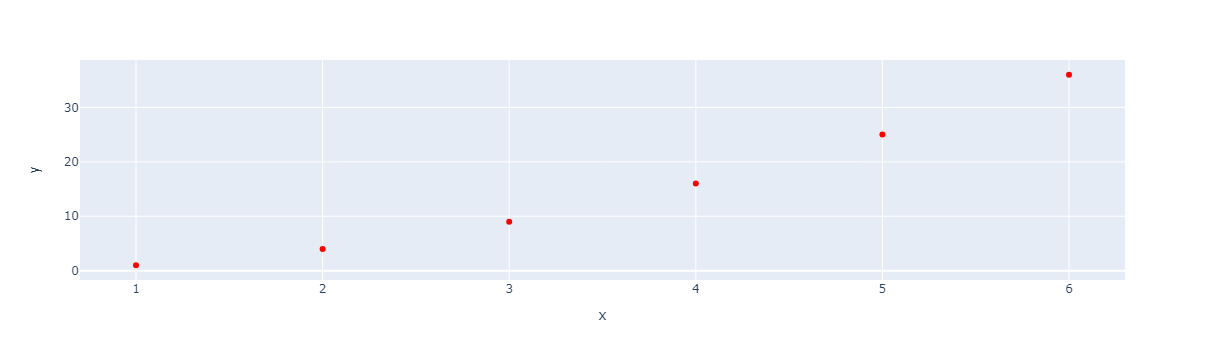

In [7]:
# 通过 update_traces 函数更新
scatter.update_traces(marker=dict(color='red'))
scatter.show(width=200, height=400)

+ `plotly.express`方式绘制多种图像在同一个图里

In [9]:
line = px.line(x=[1,2,3,4,5,6], y=[1,4,9,16,25,36])
scatter = px.scatter(x=[1,2,3,4,5,6], y=[1,4,9,16,25,36], color_discrete_sequence=['red'])

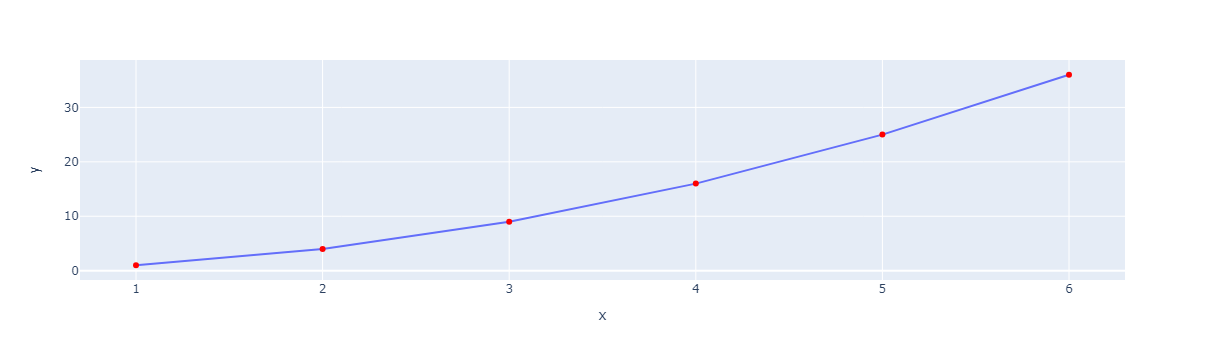

In [10]:
line.add_trace(scatter.data[0])
line.show(width=200, height=400)

+ 绘制横纵坐标的指示线  
这个涉及到[Shapes的概念](https://plotly.com/python/shapes/)

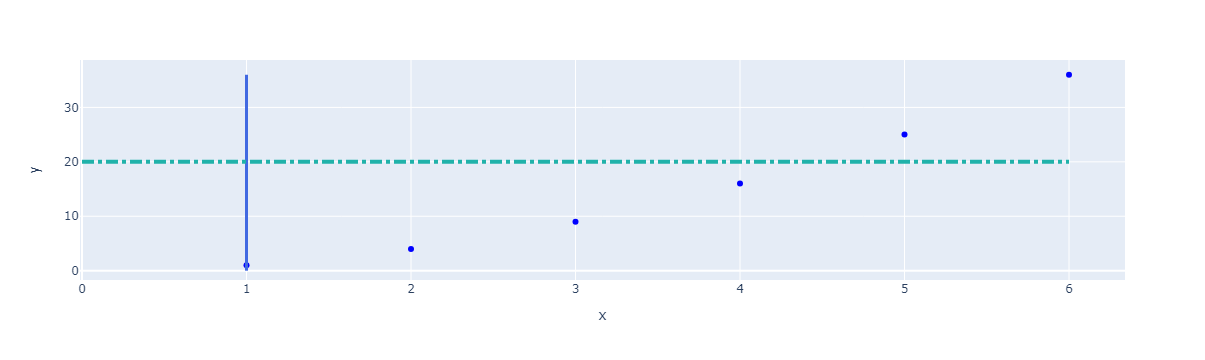

In [11]:
scatter = px.scatter(x=[1,2,3,4,5,6], y=[1,4,9,16,25,36], color_discrete_sequence=['blue'])

scatter.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0=1,y0=0,
            x1=1,y1=36,
            line=dict(
                color="RoyalBlue",
                width=3
            )
))

scatter.add_shape(
        # Line Horizontal
            type="line",
            x0=0,y0=20,
            x1=6,y1=20,
            line=dict(
                color="LightSeaGreen",
                width=4,
                dash="dashdot",
            ),
    )

scatter.show(width=200, height=400)

------

# Plotly基础

Plotly-Python官方文档 [Plotly Python Open Source Graphing Library](https://plotly.com/python/).

## Figure结构

官方文档 [The Figure Data Structure in Python](https://plotly.com/python/figure-structure)

Plotly（Python-API）中，每一个figure都可以表示为：
+ Python中的一个字典
+ `plotly.graph_objects.Figure`类的一个实例

不管是哪一种，都会被序列化成一个JSON文本对象，传给底层的Plot.js，由JavaScript库执行具体的绘图操作。

可以通过下面几种方式打印出figure内在的数据结构形式：
1. `print(fig)`
2. `fig.show('json')`，只适用于JupyterLab
3. `fig.to_dict()`
4. `fig.to_json()`


Plotly的`Figure`对象底层是**以一棵树的形式组织的，树的节点属性需要遵循一定的schema**，完整的schema定义参见官方文档 [Python Figure Reference](https://plotly.com/python/reference/index/).   

`Figure`对象的树结构的根节点有三个顶层属性:
+ `data`
+ `layout`
+ `frame`

每个顶层属性下的子节点对应于一个绘图属性，可以通过该子节点在树中的路径获取。  
比如`layout.width`获取的就是`layout`下的`width`属性。


每一个`plotly.graph_objects.Figure`对象中的属性可以通过两种方式来更新：  
1. 通过Python对象的属性获取方式，比如`fig.layout.title.font.family="Open Sans"`
2. 通过`Figure`对象的更新方法，比如`fig.update_layout(title_font_family="Open Sans")`

In [19]:
# 取得一个折线图的`Figure`对象
fig = px.line(x=[1,2,3,4,5,6], y=[1,4,9,16,25,36])
print(fig.__class__)
print('----------------------------------------')
# 打印figure内部的数据结构
print(fig)

<class 'plotly.graph_objs._figure.Figure'>
----------------------------------------
Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([1, 2, 3, 4, 5, 6], dtype=int64),
              'xaxis': 'x',
              'y': array([ 1,  4,  9, 16, 25, 36], dtype=int64),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})


### data属性

data属性存储的是具体的绘图数据和绘制的图形类别，其中每个被绘制的图形被称为一个**trace**，可以有如下几种形式：
1. 由 trace instances (e.g. [Scatter(…), Bar(…)]) 组成的 list 或者 tuple
2. 单独的一个 trace instance
3. A list or tuple of dicts of string/value properties


**每个trace都有对应的绘图类型，比如散点图，条形图等，每个trace都必须在一个subplot进行绘制（这个subplot的类型也必须和trace的类型匹配）**。

> 注意，使用plotly绘图时，常常需要自己对数据做一些聚合操作，没有seaborn那么方便。

直接获取`Figure.data`属性的话，得到的是一个tuple（虽然`print(fig)`里`data`是一个list），该tuple里的每一个元素对应于一个trace.

In [20]:
fig_data = fig.data
print(fig_data.__class__)
print(len(fig_data))

<class 'tuple'>
1


In [5]:
fig.data #或者fig['data']

(Scatter({
     'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
     'legendgroup': '',
     'line': {'color': '#636efa', 'dash': 'solid'},
     'mode': 'lines',
     'name': '',
     'orientation': 'v',
     'showlegend': False,
     'x': array([1, 2, 3, 4, 5, 6], dtype=int64),
     'xaxis': 'x',
     'y': array([ 1,  4,  9, 16, 25, 36], dtype=int64),
     'yaxis': 'y'
 }),)

In [6]:
print(fig.data[0].__class__)
fig.data[0]

<class 'plotly.graph_objs._scatter.Scatter'>


Scatter({
    'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
    'legendgroup': '',
    'line': {'color': '#636efa', 'dash': 'solid'},
    'mode': 'lines',
    'name': '',
    'orientation': 'v',
    'showlegend': False,
    'x': array([1, 2, 3, 4, 5, 6], dtype=int64),
    'xaxis': 'x',
    'y': array([ 1,  4,  9, 16, 25, 36], dtype=int64),
    'yaxis': 'y'
})

### layout属性

layout属性的值是dict，包含控制图形属性的配置，比如：
+ dimension和margin
+ title和legend
+ color axes和相应的color bars
+ 各种类型的图形的subplots

In [54]:
print(fig.layout.__class__)
fig.layout

<class 'plotly.graph_objs._layout.Layout'>


Layout({
    'template': '...', 'title': {'text': 'A Figure Specified By A Graph Object'}
})

### frame属性

frame属性用于绘制动态图时使用，也是一个dict组成的list，每一个dict是一帧

### config属性

官方文档 [Configuration in Python](https://plotly.com/python/configuration-options/#configuration-options).

这些配置主要是作为`.show()`方法的参数（参数名为`config`），用于控制图形显示时的一些功能。

-------

## Plotly绘图逻辑

详细说明见官方文档 [Creating and Updating Figures in Python](https://plotly.com/python/creating-and-updating-figures/).

plotly是基于JS库plotly.js构建的，在使用plotly的时候，最终的目的是**将所要绘制的图形信息转成一个Python字典**——对应于JSON，然后由plotly.js来处理。  
也就是说，plotly中的**图形对象的表示形式是一个JSON对象（或者Python字典）**。

### Figures As Dictionaries

使用Python原生的dict来表示一个图形，此时需要使用`plotly.io.show()`函数来进行绘图。

下面的data字典中，主要有`data`和`layout`两个key。

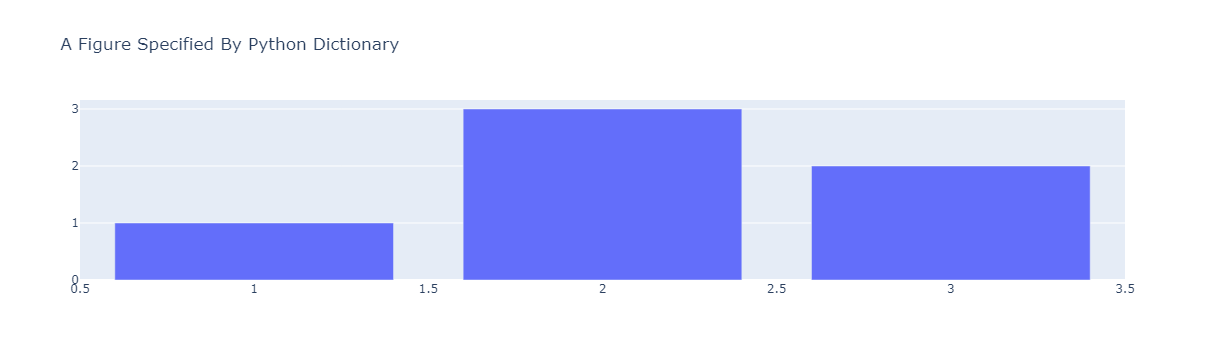

In [5]:
# To display the figure defined by this dict, use the low-level plotly.io.show function
import plotly.io as pio

# 下面的字典表示一个图形
fig = dict({
    "data": [
        # 指定一个类型为 bar 的trace
        {"type": "bar",
              "x": [1, 2, 3],
              "y": [1, 3, 2]}
    ],
    "layout": {"title": {"text": "A Figure Specified By Python Dictionary"}}
})

pio.show(fig)

### Figures as Graph Objects

上述使用python字典表示figure的方式不够灵活，需要自己设置许多属性，更加推荐的方式是使用`plotly.graph_objects`提供的类来表示一个figure，它有如下优点：
+ 提供了必要的属性和数据验证
+ 提供了对图形各个属性的便捷访问方式，比如`fig.layout`或者`fig['layout']`，甚至`fig.layout_title_text` 这种方便的下划线访问方式
+ 提供了更新图形的方式，比如`.update_layout()`和`.add_trace()`
+ 提供了导出图形的方式，比如`.write_images()`

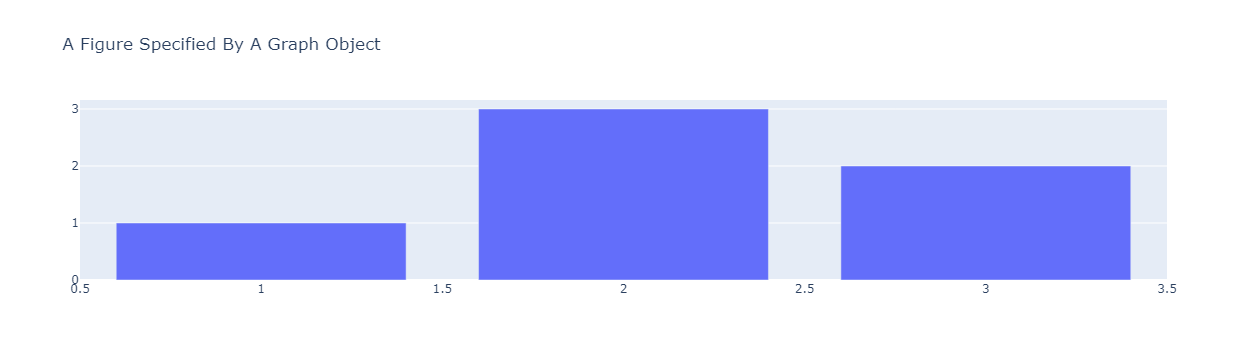

In [6]:
import plotly.graph_objects as go

# 创建一个 Bar 类型的 trace，只需要设置数据，不需要设置图形的属性
bar_trace = go.Bar(x=[1, 2, 3], y=[1, 3, 2])

# 调用 Figure 类
fig = go.Figure(
    data=bar_trace,
    # 控制布局
    layout=go.Layout( 
        title=go.layout.Title(text="A Figure Specified By A Graph Object")
    )
)

# Figure 对象上调用show方法
fig.show()

In [9]:
print(bar_trace.__class__)
print('-'*40)
bar_trace

<class 'plotly.graph_objs._bar.Bar'>
----------------------------------------


Bar({
    'x': [1, 2, 3], 'y': [1, 3, 2]
})

+ `Figure`对象的`.data`属性实际是一个tuple，里面存放了各个trace的对象。

In [10]:
print(fig.data.__class__)
print('-'*40)
fig.data

<class 'tuple'>
----------------------------------------


(Bar({
     'x': [1, 2, 3], 'y': [1, 3, 2]
 }),)

In [12]:
scatter_trace=go.Scatter(x=[1,2,3], y=[1,4,9], mode='lines+markers', name='trace_1')
print(scatter_trace.__class__)
print('-'*40)
scatter_trace

<class 'plotly.graph_objs._scatter.Scatter'>
----------------------------------------


Scatter({
    'mode': 'lines+markers', 'name': 'trace_1', 'x': [1, 2, 3], 'y': [1, 4, 9]
})

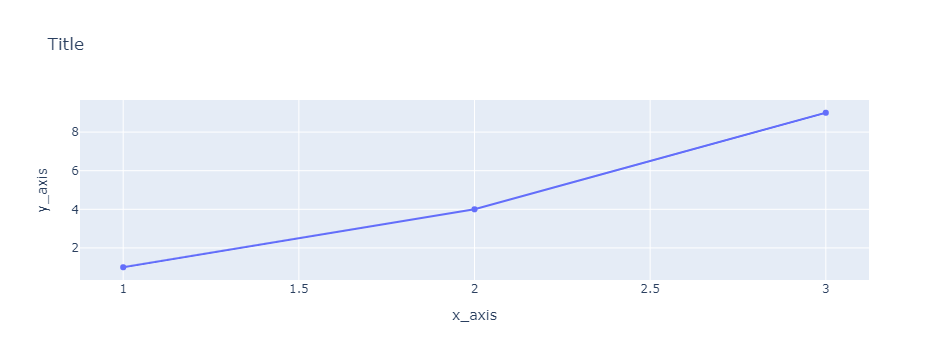

In [14]:
layout = go.Layout(
    title='Title',
    xaxis=go.layout.XAxis(title='x_axis'),
    yaxis=go.layout.YAxis(title='y_axis')
)
fig = go.Figure(data=scatter_trace,layout=layout)
fig.show()

### 将Figure对象转成dict或者JSON

In [3]:
fig.to_dict()

{'data': [{'x': [1, 2, 3], 'y': [1, 3, 2], 'type': 'bar'}],
 'layout': {'title': {'text': 'A Figure Specified By A Graph Object'},
  'template': {'data': {'barpolar': [{'marker': {'line': {'color': '#E5ECF6',
        'width': 0.5}},
      'type': 'barpolar'}],
    'bar': [{'error_x': {'color': '#2a3f5f'},
      'error_y': {'color': '#2a3f5f'},
      'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}},
      'type': 'bar'}],
    'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f',
       'gridcolor': 'white',
       'linecolor': 'white',
       'minorgridcolor': 'white',
       'startlinecolor': '#2a3f5f'},
      'baxis': {'endlinecolor': '#2a3f5f',
       'gridcolor': 'white',
       'linecolor': 'white',
       'minorgridcolor': 'white',
       'startlinecolor': '#2a3f5f'},
      'type': 'carpet'}],
    'choropleth': [{'colorbar': {'outlinewidth': 0, 'ticks': ''},
      'type': 'choropleth'}],
    'contourcarpet': [{'colorbar': {'outlinewidth': 0, 'ticks': ''},
      'type': 'contourca

In [4]:
fig.to_json()

'{"data":[{"type":"bar","x":[1,2,3],"y":[1,3,2]}],"layout":{"template":{"data":{"bar":[{"error_x":{"color":"#2a3f5f"},"error_y":{"color":"#2a3f5f"},"marker":{"line":{"color":"#E5ECF6","width":0.5}},"type":"bar"}],"barpolar":[{"marker":{"line":{"color":"#E5ECF6","width":0.5}},"type":"barpolar"}],"carpet":[{"aaxis":{"endlinecolor":"#2a3f5f","gridcolor":"white","linecolor":"white","minorgridcolor":"white","startlinecolor":"#2a3f5f"},"baxis":{"endlinecolor":"#2a3f5f","gridcolor":"white","linecolor":"white","minorgridcolor":"white","startlinecolor":"#2a3f5f"},"type":"carpet"}],"choropleth":[{"colorbar":{"outlinewidth":0,"ticks":""},"type":"choropleth"}],"contour":[{"colorbar":{"outlinewidth":0,"ticks":""},"colorscale":[[0.0,"#0d0887"],[0.1111111111111111,"#46039f"],[0.2222222222222222,"#7201a8"],[0.3333333333333333,"#9c179e"],[0.4444444444444444,"#bd3786"],[0.5555555555555556,"#d8576b"],[0.6666666666666666,"#ed7953"],[0.7777777777777778,"#fb9f3a"],[0.8888888888888888,"#fdca26"],[1.0,"#f0f92

------------------

# 创建图形

plotly里有两种方式来创建图形：
1. 通过构造函数`plotly.graph_objects.Figure()`来创建，也就是上面展示的那样——这种方式使用的是更底层的API；
2. 通过`plotly.express`来创建——这种方式是对上面的封装，更加容易使用。

## 通过构造函数`Figure()`创建

1. 首先导入`graph_objects`
2. 使用`graph_objects.Figure()`创建`Figure`对象，同时使用`graph_objects.XXX`来指定绘制的图形。  
  需要设置两个属性：
   + `data`属性
   + `layout`属性
3. 在返回的fig上使用`.show()`方法显示图形

注意，**这种方式创建图形时，坐标轴，图例，标题等信息需要自己手动设定，不会自动生成**。


`data`属性通常是一个list，里面包含了需要绘图的traces.  
每个trace都是由`plotly.graph_objects.XXX()`类（名称首字母大写）创建的对象，这些种类图形绘图API的一些**公共参数**如下：
+ `name`：trace的名称，会被作为legend中对应于该trace的图例项
+ `showlegend`：是否显示该trace对应的图例项
+ `opacity`：透明度
+ `visiable`：是否可见
+ `x`, `y`：横纵坐标对应的绘图数据
+ `text`：对应于每对`(x,y)`的文本，list of str
+ `xaxis`, `yaxis`：设置当前trace使用的坐标轴，当`Figure`中有多个子图时，这里可以指定绘制在哪个子图上。   
取值通常为`x, y`, `x2, y2`，表示对应于第几个坐标轴。
+ `legendgroup`：对应图例项的组别
+ `legendgrouptitle`：对应图例项组别的名称


> `plotly.graph_objects.XXX()` 的绘图接口偏向底层，所以其中的`x`, `y`等数据，只能单独传入，**这类API不像 `plotly.express` 那样支持使用DataFrame**。


`layout`的属性设置可以参考下面的 *<更新 Layout>* 章节。

In [24]:
# 第1步
import plotly.graph_objects as go

# 第2步
fig = go.Figure(
    # 1.设置data属性，这里调用 Bar函数来生成图形类别，而不是手动指定
    data=[ go.Bar(x=[1, 2, 3], y=[1, 3, 2]) ], 
    # 2.设置layout属性
    layout=go.Layout(
        title=go.layout.Title(text="A Figure Specified By A Graph Object")
    )
)

print(fig.__class__)

# 第3步
# fig.show()
# 在jupyter中，直接fig也可以显示图形

<class 'plotly.graph_objs._figure.Figure'>


## 通过`plotly.express`创建

官方文档 [Plotly Express in Python](https://plotly.com/python/plotly-express/).   

`plotly.express` 接受的数据格式可以参考文档 [Plotly Express Arguments in Python](https://plotly.com/python/px-arguments).   

`plotly.express`绘图的一些特点：
1. 通过`plotly.express`可以更加简单的创建图形，只需要传入绘图的数据就行，不需要手动设定`layout`，省去了第二步的繁琐步骤。  
1. `plotly.express`里可以直接**传入DF，然后选择其中的列作为绘图数据**。  
1. **`plotly.express` 绘制的图形会自动生成坐标轴、图例等信息**。
1. `px.XXX`等绘图函数返回的也是一个`Figure()`对象.



所有的`plot.express.xxx`绘图函数主要是**面向 dataframe** 的数据绘图，它里面的参数，大部分都是指定 DF 里的列。   

常见的一些通用参数，如下所示：
+ `data_frame`，绘图的DF，**可以省略**。   
实际上，省略之后，会隐式的用其他参数（比如`x`, `y`）来构建一个DF.

+ 以下的这些参数，取值可以为 str, int, Series 或者 array-like.   
**当为 str 或者 int 时，指定的是 DF 里的列；Series 或者 array-like 类型时，就是作为数据**
  + `x`, `y`: 指定横纵坐标的特征列
  + `color`: 指定颜色的映射特征，**注意，不能使用 "red" 这种方式直接指定颜色**，它会被解释为 DF 里的某一列
  + `hover_name`：指定每个数据点在鼠标悬浮时的整个数据标签的名称
  + `hover_data`: 指定鼠标悬浮时显示哪些数据，可以参考文档 [Customizing Hover text with Plotly Express](https://plotly.com/python/hover-text-and-formatting/#customizing-hover-text-with-plotly-express)
  + `text`: 每个 (x, y) 点上显示的文本
  + `facet_row`, `facet_col`: 指定用于分隔数据的列，之后会**用对应的子集绘制子图**。
  + `size`: 指定点的大小映射——不一定所有图形都有
  + `symbol`: 点的形状映射——不一定所有图形都有
  + `error_x`, `error_y`:
  + `error_x_minus`, `error_y_minus`: 
  + `custom_data`:    
.

+ `title`: **图的标题**
+ `width`, `height`: **指定图形的大小**.
+ `labels`: dict，用于指定坐标轴显示的名称，key 对应于 DF 里的列名称, value 是实际想显示的名称
+ `orientation`: 绘图方向，`v`或者`h`.
+ `opacity`: 指定透明度.
+ `log_x`, `log_y`: 是否对坐标轴做对数变换，默认为False
+ `range_x`, `range_y`: 指定坐标轴的范围，格式为`[min, max]`
+ `facet_row_spacing`, `facet_col_spacing`: 分组子图的边距

图形属性映射相关的参数：
+ `category_orders`: 指定分类特征里取值的显示顺序
+ `color_discrete_sequence`: list of str， **这个才是使用 "red", "blue" 等字符串指定颜色的参数**    
当`color`指定的特征不是连续变量时，该特征每个取值对应的颜色就从这个列表里取，顺序由`category_orders`确定
+ `color_discrete_map`: 
+ `color_continuous_scale`: list of str，当`color`为连续变量时的颜色映射
+ `symbol_sequence`: list of str，当`symbol`指定的是离散变量时，设定的符号映射
+ `symbol_map`:



有一个地方要特别注意：
>使用`color`来指定映射时，比如
>```python
>fig = px.scatter(data_frame=data, x='x', y='y',color='group', color_discrete_sequence=["red", "magenta", "blue"])`
>```
根据其中用于分组的`group`字段类型，返回的结果是不一样的：
>  + 如果`group`字段是一个连续特征，那么返回的`fig`里，就只有 1 条 trace
>  + 如果`group`字段是一个离散特征(str之类的)，那么返回的`fig`里，就会有多条 trace，数量等于`group`的分组数。  

In [8]:
import plotly.express as px

In [12]:
fig = px.bar(x=[1, 2, 3], y=[1, 3, 2])
fig.__class__

plotly.graph_objs._figure.Figure

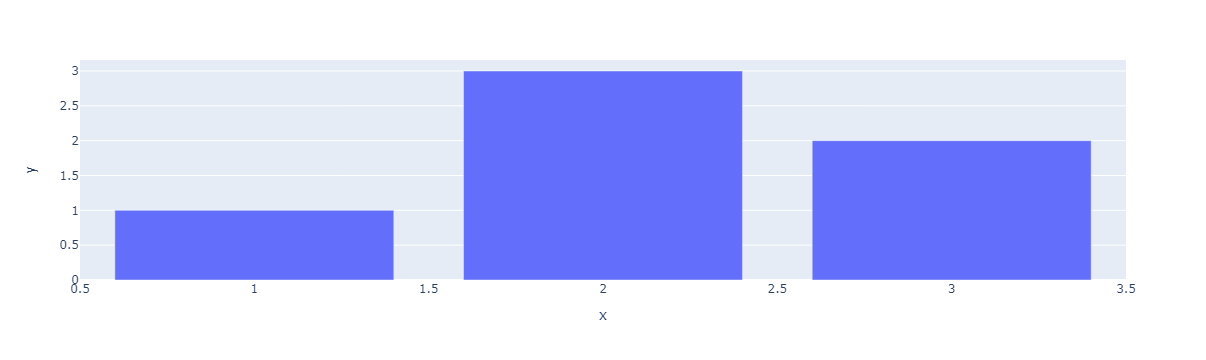

In [13]:
fig.show(width=200, height=400)

## 子图的构造

详细见官方文档 [Subplots in Python](https://plotly.com/python/subplots/).

有两种方式构造子图：
1. 使用`plotly.subplots.make_subplots`构建子图的对象`plotly.graph_objs._figure.Figure`，然后使用下面两种方法之一来添加子图，同时设置子图位置：
   + `add_trace(trace=, row=, col=)`，添加**一条**trace
   + `add_traces(data=, rows=, cols= )`，添加**多条**trace
2. **使用plotly express的话，只能根据传入的DF里的变量来分割子图(faceting by a given data dimension)，不能构造任意形状的子图**。  
实际上，plotly express 内部也是使用的`make_subplots`来绘制的子图。

> `make_subplots`返回的`Figure`对象和普通绘制的`Figure`对象是一样的，不是特定的子图对象。  
> 同样的，对于plotly express来说，使用它绘制的faccet子图仍然是`Figure`对象，也可以在每个子图上分别添加trace.


`plotly.subplots.make_subplots`的主要参数如下([API文档](https://plotly.com/python-api-reference/generated/plotly.subplots.make_subplots.html))：
+ `rows`, `cols`：int, 指定子图的布局.
+ `shared_xaxes`, `shared_yaxes`：是否共享坐标轴
+ `subplot_titles`: list of str，设置各个子图的标题。
+ `figure`: 指定绘图的Figure，默认会创建一个新的。
+ `x_title`, `y_title`: str, 指定**整个图形**的x和y轴的标题.
+ `column_titles`, `row_titles`: list of str，指定行列的title.——可能会和 `subplot_titles` 位置冲突。
+ `column_widths`, `row_heights`: 指定各个子图的大小，提供更加精细化的控制。

绘制多个子图时，建议采用如下的步骤，更为方便：
  1. `fig = make_subplots(rows, cols)` 构建包含多子图的 Figure 对象
  2. 使用 `subfig = px.xxx` 绘制对应的图形
  3. 根据 `px` 返回的 `subfig` 里的 **trace 个数**——这个要特别注意，调用 `fig.add_trace()` 或者 `fig.add_traces()` 方法将 px 得到的 trace 添加到对应位置的子图上。

  
实际上，plotly绘制多个子图时，会在图形布局中创建多对`xaxis-yaxis`，比如有3个子图，就会另外创建两个`xaxis2, yaxis2, xaxis3, yaxis3`.

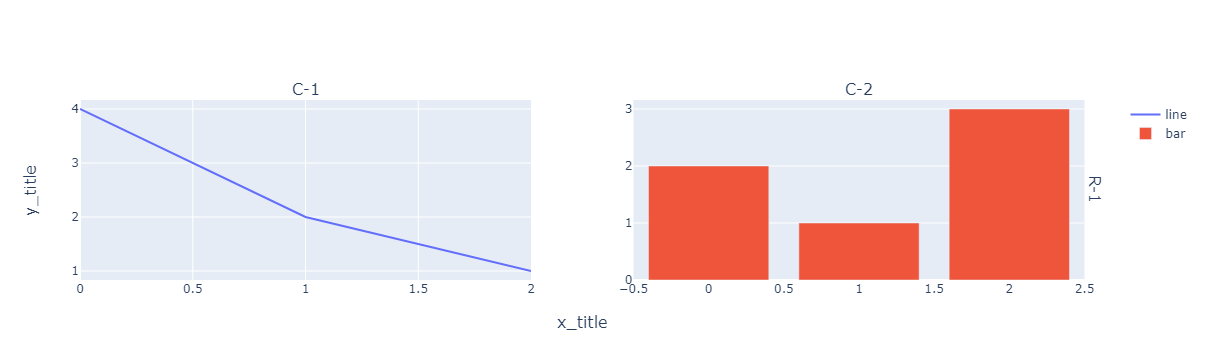

In [15]:
from plotly.subplots import make_subplots

# fig = make_subplots(rows=1, cols=2, subplot_titles=['subplot-1', 'subplot-2'], x_title='x_title', y_title='y_title')
fig = make_subplots(rows=1, cols=2, x_title='x_title', y_title='y_title', column_titles=['C-1', 'C-2'], row_titles=['R-1'])

# 下面每个trace的name会作为图例的名称显示在旁边
fig.add_trace(go.Scatter(y=[4, 2, 1], mode="lines", name='line'), row=1, col=1)
fig.add_trace(go.Bar(y=[2, 1, 3], name='bar'), row=1, col=2)

fig.show()

注意下面子图的坐标轴和取值变量对应关系： 
+ `data` ：   
  + 第一幅子图 Scatter，坐标轴对应关系为`xaxis`-->`x`, `yaxis`-->`y`
  + 第二幅子图 Bar ，坐标轴是`xaxis`-->`x2`, `yaxis`-->`y2`
+ `layout`：
  + 第一幅子图 Scatter，坐标轴对应关系为`xaxis.anchor`-->`x`, `yaxis.anchor`-->`y`
  + 第二幅子图 Bar，坐标轴是`xaxis2.anchor`-->`x2`, `yaxis2.anchor`-->`y2`
  

多幅子图时，以此类推。

In [16]:
fig.data

(Scatter({
     'mode': 'lines', 'name': 'line', 'xaxis': 'x', 'y': [4, 2, 1], 'yaxis': 'y'
 }),
 Bar({
     'name': 'bar', 'xaxis': 'x2', 'y': [2, 1, 3], 'yaxis': 'y2'
 }))

In [17]:
fig.layout

Layout({
    'annotations': [{'font': {'size': 16},
                     'showarrow': False,
                     'text': 'C-1',
                     'x': 0.22,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,
                     'yanchor': 'bottom',
                     'yref': 'paper'},
                    {'font': {'size': 16},
                     'showarrow': False,
                     'text': 'C-2',
                     'x': 0.76,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,
                     'yanchor': 'bottom',
                     'yref': 'paper'},
                    {'font': {'size': 16},
                     'showarrow': False,
                     'text': 'R-1',
                     'textangle': 90,
                     'x': 0.98,
                     'xanchor': 'left',
                     'xref': 'paper',
                     'y': 0.5,
    

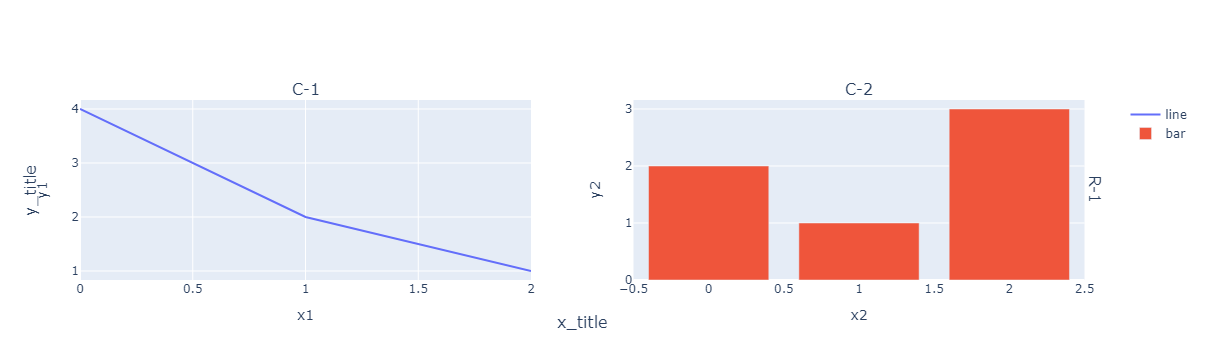

In [18]:
# 这里对照着上面的layout更新各个子图的坐标轴
fig.update_layout(
    xaxis_title_text='x1',
    yaxis_title_text='y1',
    xaxis2_title_text='x2',
    yaxis2_title_text='y2',
)
fig.show()

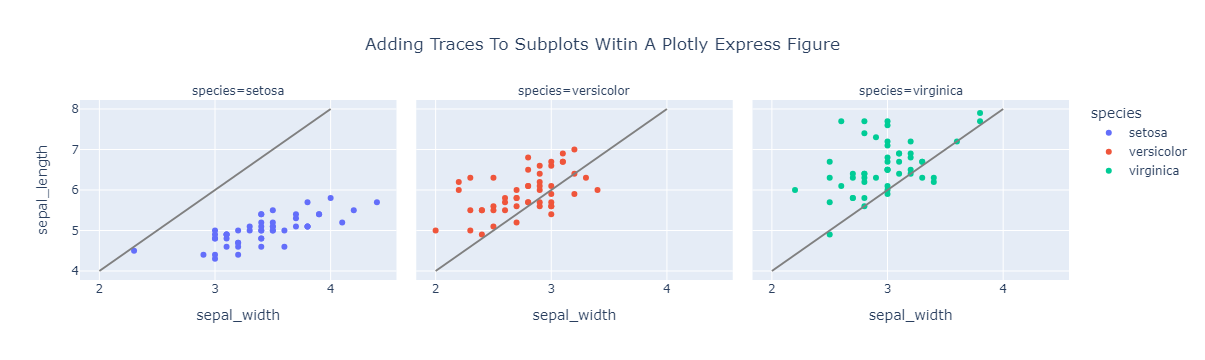

In [22]:
df = px.data.iris()
# 使用 express 根据 species 来分割数据集绘制子图
fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species", facet_col="species",
                 title="Adding Traces To Subplots Witin A Plotly Express Figure")
# 参考线的trace
reference_line = go.Scatter(x=[2, 4],
                            y=[4, 8],
                            mode="lines",
                            line=go.scatter.Line(color="gray"),
                            showlegend=False)
# 向每个子图中添加同一个参考线的trace
fig.add_trace(reference_line, row=1, col=1)
fig.add_trace(reference_line, row=1, col=2)
fig.add_trace(reference_line, row=1, col=3)
# 修改一下 图表题 的位置为居中
fig.update_layout(title=dict(x=0.5))
fig.show()

In [20]:
fig.data

(Scatter({
     'hovertemplate': 'species=setosa<br>sepal_width=%{x}<br>sepal_length=%{y}<extra></extra>',
     'legendgroup': 'setosa',
     'marker': {'color': '#636efa', 'symbol': 'circle'},
     'mode': 'markers',
     'name': 'setosa',
     'orientation': 'v',
     'showlegend': True,
     'x': array([3.5, 3. , 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1, 3.7, 3.4, 3. , 3. ,
                 4. , 4.4, 3.9, 3.5, 3.8, 3.8, 3.4, 3.7, 3.6, 3.3, 3.4, 3. , 3.4, 3.5,
                 3.4, 3.2, 3.1, 3.4, 4.1, 4.2, 3.1, 3.2, 3.5, 3.1, 3. , 3.4, 3.5, 2.3,
                 3.2, 3.5, 3.8, 3. , 3.8, 3.2, 3.7, 3.3]),
     'xaxis': 'x',
     'y': array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8, 4.3,
                 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. , 5. , 5.2,
                 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4, 5.1, 5. , 4.5,
                 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. ]),
     'yaxis': 'y'
 }),
 Scatter({
     'hovertempl

In [31]:
fig.layout

Layout({
    'annotations': [{'font': {},
                     'showarrow': False,
                     'text': 'species=setosa',
                     'x': 0.15999999999999998,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,
                     'yanchor': 'bottom',
                     'yref': 'paper'},
                    {'font': {},
                     'showarrow': False,
                     'text': 'species=versicolor',
                     'x': 0.49999999999999994,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,
                     'yanchor': 'bottom',
                     'yref': 'paper'},
                    {'font': {},
                     'showarrow': False,
                     'text': 'species=virginica',
                     'x': 0.8399999999999999,
                     'xanchor': 'center',
                     'xref': 'paper',
                 

## Plotly Python库的API结构

完整的API文档见 [Python API reference for `plotly`](https://plotly.com/python-api-reference/).

常用的三个子模块是：

一、[`plotly.express`](https://plotly.com/python-api-reference/plotly.express.html) : high-level interface for data visualization.  
这个里面大部分都是封装好的高级绘图**函数**，比如：
+ `px.scatter()`
+ `px.line()`
+ `px.bar()`



二、[`plotly.graph_objects`](https://plotly.com/python-api-reference/plotly.graph_objects.html#) : low-level interface to figures, traces and layout.  
这里面主要分为三大部分:
+ Figure相关   
只有一个[`plotly.graph_objects.Figure`类](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html)，主要有以下几个方法
  + `Figure([data, layout, frames, skip_invalid])`，类的构造方法
  + `Figure.show(*args, **kwargs)`，显示图形的方法
  + `Figure.add_traces(data[, rows, cols, …])`，添加trace
  + `Figure.update_traces([patch, selector, row, …])`，更新trace属性
  + `Figure.update_layout([dict1, overwrite])`，更新layout   
.
+ Layout相关   
  + [`plotly.graph_objects.Layout`类](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Layout.html)
  + `plotly.graph_objects.layout` 模块，里面提供了各种用于控制Layout本身的属性类。   
.
+ 各种类型的绘图Trace.   
 要注意的是，每个类型的Trace 除了有对应的类（大写）外，还有对应的模块（小写）用于控制该类Trace中的各种属性。   
 以下举个例子：
  + `plotly.graph_objects.Scatter`类（大写），用于绘制点或者直线的类
  + `plotly.graph_objects.scatter`模块（小写），里面有用于控制点或者直线的各种属性的类
  


三、[`plotly.subplots`](https://plotly.com/python-api-reference/plotly.subplots.html#subplots) : helper function for laying out multi-plot figures.  
这个模块里就一个`make_subplots()`函数。




总结下来，还是在下面的具体绘图中熟悉这些API比较好.

In [5]:
# 一个是具体的类，另一个是模块
print(go.Layout)
print(go.layout)

<class 'plotly.graph_objs._layout.Layout'>
<module 'plotly.graph_objs.layout' from 'D:\\MyProgramFiles\\Anaconda\\lib\\site-packages\\plotly\\graph_objs\\layout\\__init__.py'>


In [6]:
print(go.Scatter)
print(go.scatter)

<class 'plotly.graph_objs._scatter.Scatter'>
<module 'plotly.graph_objs.scatter' from 'D:\\MyProgramFiles\\Anaconda\\lib\\site-packages\\plotly\\graph_objs\\scatter\\__init__.py'>


-----

# 图形的渲染与导出


## 图形渲染
参考官方文档 [Displaying Figures in Python](https://plotly.com/python/renderers/).

plotly的交互式显示依赖于底层的JS库，所以显示对应的图形在大多数情况下都需要某种基于浏览器的支持。

总的来说，有如下几种显示方式（优先级依次降低）：
1. 使用默认的`renderers`框架进行渲染显示——这个是最主要的使用方式
2. 使用 Dash 进行渲染
3. 在 ipywidgets 环境下，使用 FigureWidget 组件渲染 —— 这个用的不多
4. 导出成 html 文件，使用浏览器打开
5. 导出成 PNG, SVG 等静态图片——这样就**失去了交互性**

在如下的环境下，plotly会自动选择`renderers`框架：**Jupyter Notebook, JupyterLab, Python interactive shell, Google Colaboratory, Kaggle等**。

**在PyCharm中，是无法显示plotly的交互式图形的**：如果在pycharm中使用run脚本的方式，脚本执行时会打开一个浏览器窗口，显示对应的图形，但是不能刷新和保存；如果是交互式开发的话，也没有办法像matplotlib或者seaborn那样显示在SciView中。

In [2]:
# 显示可用的renders
import plotly
print(plotly.io.renderers)

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



## 图形导出

参考：
+ [Interactive HTML Export in Python](https://plotly.com/python/interactive-html-export/)：导出成html

```python
fig.write_html('path/to/figure.html')
```

+ [Static Image Export in Python](https://plotly.com/python/static-image-export/)：导出成静态图片，需要安装`kaleido`包

```shell
$ pip install -U kaleido
$ conda install -c conda-forge python-kaleido
```
```python
fig.write_image('path/to/figure.png')
```

---

# 图形的更新-KEY

Plotly有关更新图形的相关文档主要是如下两个：
1. 教程文档 [Creating and Updating Figures](https://plotly.com/python/creating-and-updating-figures/).   
这个文档用于快速入门。
2. 手册文档 [**Python Figure Reference**](https://plotly.com/python/reference/index/).  
详细列出了所有可以设置的属性，可以查询到如下信息：
   + `data`下有哪些种类的`trace`，以及每种trace所含有的属性.   
比如Scatter的trace里，mode属性控制绘制的是点，线，还是点+线；marker属性控制的是点或者线的size，opacity，color，线的形状等等。
   + layout下各种图形属性的控制   
比如图形title的font，legend等等。


plotly里对于图形的**设置和更新**主要分为三个部分，也对应`Figure`对象的3个API:
1. `Figure.add_traces()`：添加traces
2. `Figure.update_traces()`：更新某个trace的属性
3. `Figure.update_layout()`：更新图形的布局


另外，对于`plotly`来说：
> `plotly.express`提供的函数**无法直接对图形进行更加精细的控制，比如设置散点图的固定颜色，点的大小等等**。
> 如果需要修改这些属性，必须要通过返回的`Figure`对象的`.update_trace()`函数进行更新。



## 增加图形

`Figure`对象有两个方法可以添加Trace（**注意函数名的单复数和参数的单复数形式**）:
1. `add_trace(trace=, row=, col=)`方法，添加 **一条** trace，详见[`plotly.graph_objects.Figure.add_trace()`](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html#plotly.graph_objects.Figure.add_trace).
2. `add_traces(data=, rows=, cols=)`方法，添加 **多条** trace，详见[`plotly.graph_objects.Figure.add_traces()`](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html#plotly.graph_objects.Figure.add_traces).

如果是子图，还可以同时设置添加的子图位置。

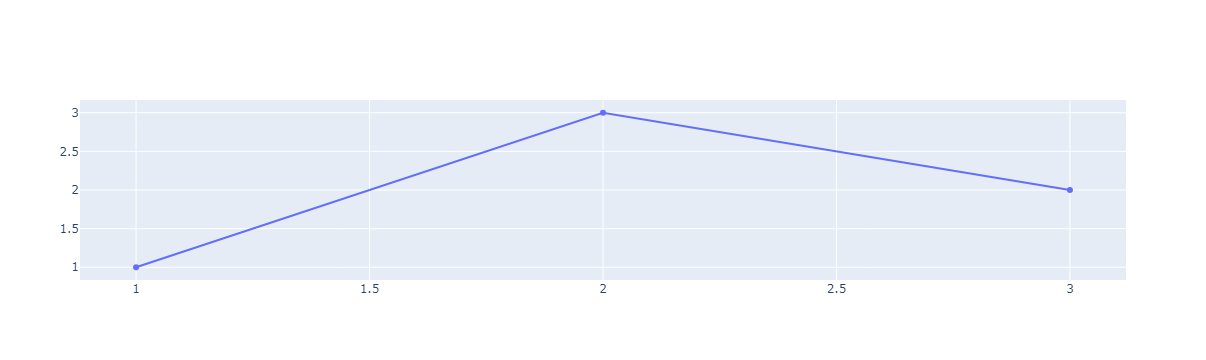

In [15]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=[1, 2, 3], y=[1, 3, 2]))

fig.show(width=200, height=300)

+ 如果要向子图中增加trace，可以指定位置

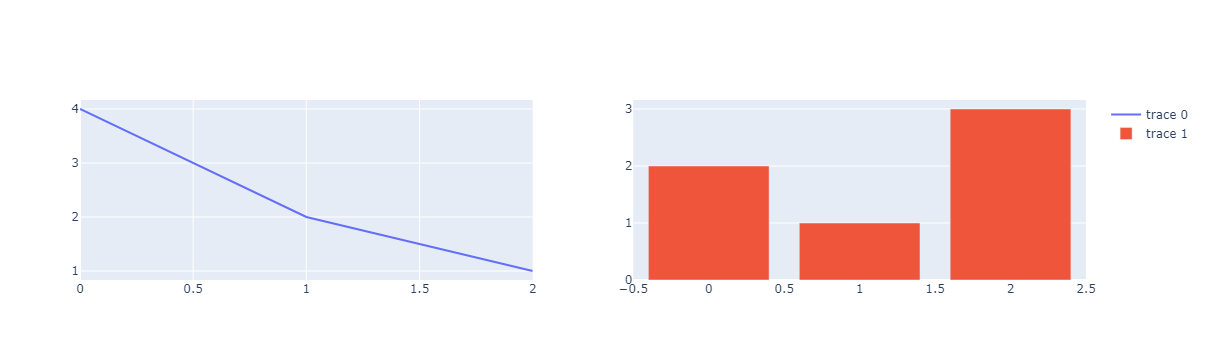

In [16]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2)

# row 和 col 参数指定子图
fig.add_trace(go.Scatter(y=[4, 2, 1], mode="lines"), row=1, col=1)
fig.add_trace(go.Bar(y=[2, 1, 3]), row=1, col=2)

fig.show(width=200, height=300)

## 更新 Traces

通过`Figure`对象的`update_traces()`方法（[API文档](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html#plotly.graph_objects.Figure.update_traces).）

下面使用的这些属性可以在 [Python Figure Reference](https://plotly.com/python/reference/index/) 的不同type的trace项目里找到，下面的这个例子使用的是Scatter这个type里的属性。

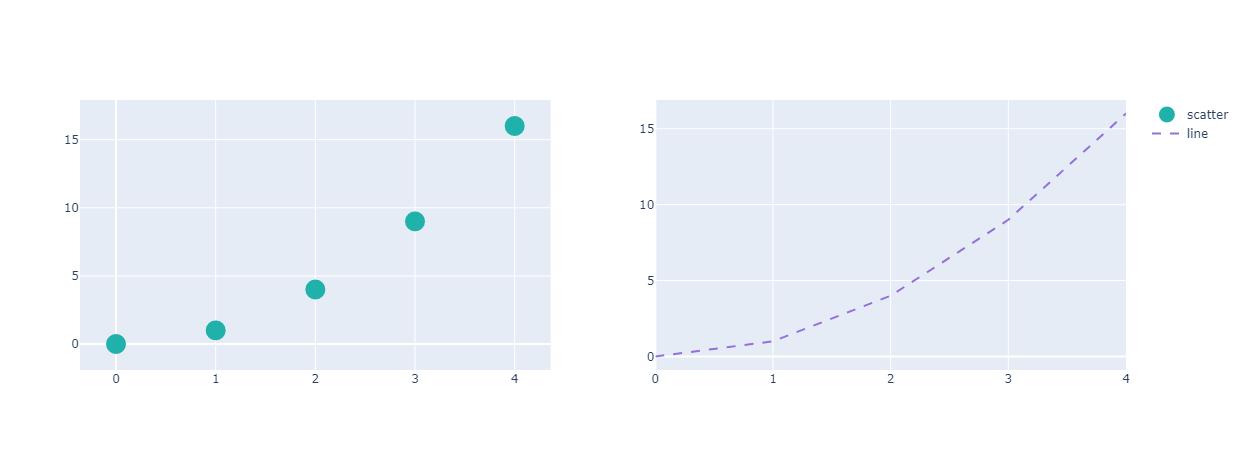

In [109]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2)
fig.add_scatter(x=[0,1,2,3,4], y=[0,1,4,9,16],
                
                # mode='markers'表示只绘制点，并且点的属性用 marker={}来设置
                mode="markers",
                marker={'size':20, 'color':"LightSeaGreen"},
                name="scatter",
                row=1, col=1)

fig.add_scatter(x=[0,1,2,3,4], y=[0,1,4,9,16],
                
                # mode='lines'表示只绘制线，并且线的属性用 line={} 来设置
                mode="lines",
                line={'width':2, 'color':"MediumPurple", 'dash':'dash'},
                name="line",
                row=1, col=2)

fig.show()

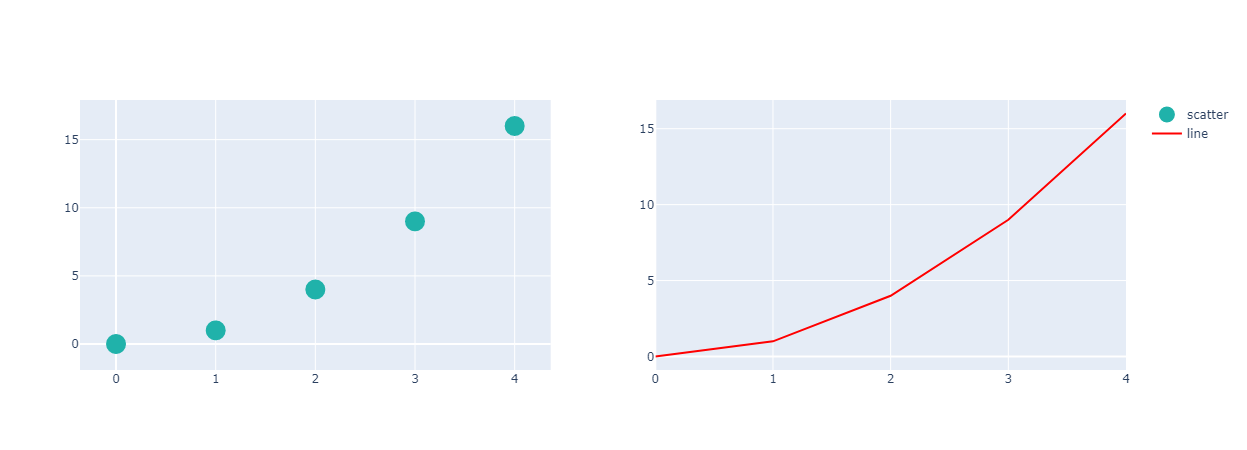

In [107]:
fig.update_traces(
    # 需要更新的属性
    marker={'color':'Red'},
    
    # 使用 selector来选择需要更新的部分，这里选择了 mode=lines,也就是上面的线图，
    selector={'mode':'lines'}
    
    # 如果是子图中是不同类型的trace,可以使用如下的方式来选择，下面是选择Bar图来更新
    #selector={'type':'bar'}
    # 也可以通过 row, col 参数指定要更新的trace
    #row=1, col=2
)
fig.show()

## 更新 Layout

通过`Figure`对象的`update_layout()`方法实现（[API文档](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html#plotly.graph_objects.Figure.update_layout)）.  

`layout`属性可以更新的全部内容见官方文档 [Python Figure Reference: layout](https://plotly.com/python/reference/layout/).    
下面列出了一些常用的属性：

```python
fig.update_layout(
    autosize = True,          // 自动控制绘图大小，也就是自动适应 width 和 hegith 的大小
    width = 700,
    height = 450,
    
    // 设置 title
    title = dict(
        text = '',       // 设置title的文本内容
        x = 0.5,         // 设置title的位置，取值为 [0,1] 之间的小数
        y = 0.5,
        // 设置字体
        font = dict(
            size=1, color='red', family=''
        ),
        // 设置填充的边界宽度
        pad = dict(
            // 以下分别是 left, right, top, bottom 的边距
            b=0, l=0, f=0, t=0
        ),
    ),
    
    // 设置 legend
    showlegend = True,
    legend = dict(
        title = dict(
            text = '',      // 图例的名称，默认下不显示。注意，不是图例中每个项目的名称，每个项目的名称由trace的name决定
            side = 'top'    // 图例位置，取值为：top, left, top left
        ),
    ),
    
    // 控制图形边距
    margin = dict(
        autoexpand = True,    //
        pad = 0,              // 填充大小，单位为px
        // 以下分别是 left, right, top, bottom 的边距
        l=30, r=30, t=30, b=30
    ),
    
    hovermode = 'closest',    // 取值为: x, y, closest, False, x unified, y unified
    
    // 以下为特殊图形里的控制参数，详细含义见对应的绘图函数即可
    barmode = '',
    barnorm = '',
    boxmode = '',
    violinmode = '',
    waterfallmode = '',
    funnelmode = ''
)
```

上面只是列举了一部分，实践中，**可以通过`fig.layout`查看当前`layout`的细节，然后对照着里面的key更新内容就可以了**。

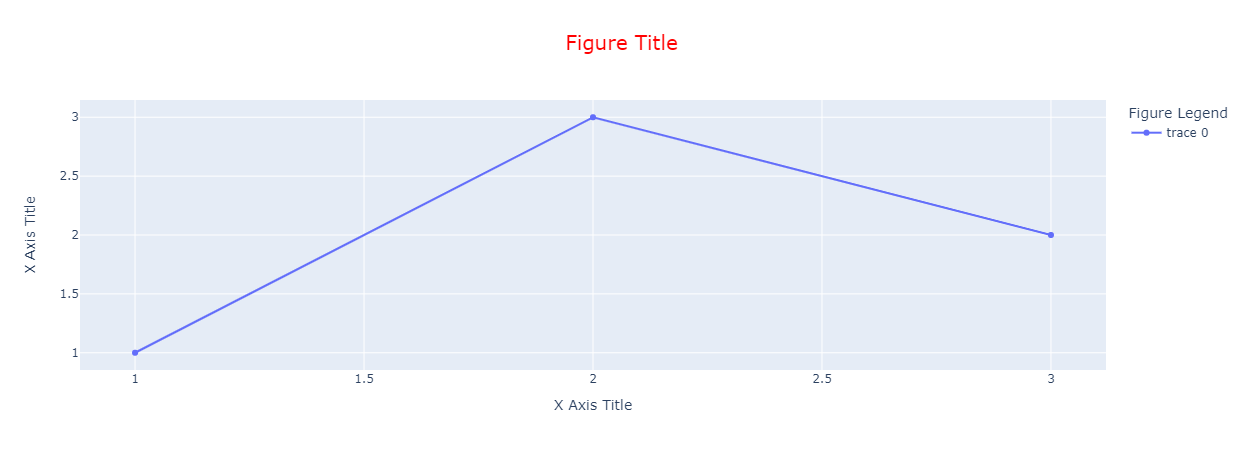

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[1, 3, 2]))

# 这里使用了 属性+下划线 的方式实现了快速访问设置
fig.update_layout(
    title_text="Figure Title",
    title_font_size=20,
    title_font_color='red',
    title_x=0.5,
    showlegend=True,
    legend_title_text='Figure Legend',
    legend_font_size=12,
    xaxis_title="X Axis Title",
    yaxis_title="X Axis Title",
    width=800,   #绘图宽度
    height=450   #绘图高度
)

# 另一种使用字典的更新方式
# fig.update_layout(
#     title={
#         'text':'Figure Title',
#         'font':{'size':20, 'color':'red'},
#         'x':0.5
#     },
#     showlegend=True,
#     legend={
#         'title':{'text':'Figure Legend'},
#         'font':{'size':12}
#     },
#     width=800,
#     height=450
# )

fig.show()

## 使用Figure对象属性的方式修改


上述的这些嵌套属性，在设置的时候，可以通过下划线来快速访问或者设置，详见 [Magic Underscore Notation](https://plotly.com/python/creating-and-updating-figures/#magic-underscore-notation)  
```python
fig = go.Figure(
    data=[go.Scatter(y=[1, 3, 2], line=dict(color="crimson"))],
    
    # 通过嵌套字典的方式设置 layout.title.text 属性
    # layout=dict(title=dict(text="A Graph Object Figure With dictionary Notation"))
    
    # 通过下划线的快捷方式设置 layout.title.text 属性
    layout_title_text="A Graph Object Figure With Magic Underscore Notation"
    
)

# fig.show()
```

In [12]:
fig.layout.title.text

'A Figure Specified By A Graph Object'

In [13]:
fig.layout.title.text = 'A Figure Specified By A Graph Object + Add something'
fig.layout.title.text 

'A Figure Specified By A Graph Object + Add something'

In [16]:
fig.update_layout(title_text='new title')
fig.layout.title.text

'new title'

## 其他的一些更新方法

除了上述通用的 3 类更新图形的方法外，plotly还提供了如下更新图形指定部分的快捷方法。

### 更新 Figure Axes

官方文档：
+ [Python Figure Reference: `layout.xaxis`](https://plotly.com/python/reference/layout/xaxis/)
+ [Python Figure Reference: `layout.yaxis`](https://plotly.com/python/reference/layout/yaxis/)

```python
fig.update_xaxes(
    // 指定要更新的坐标轴
    anchor = 'x',
    
    // 坐标轴名称
    title = dict(
        text = ''
    ),
    
    automargin = True,  // 自动设置坐标轴边距
    autorange = True,   // 自动设置坐标轴范围
    domain = [0,1],     // 设置的坐标轴范围
    range = [],
)
```

----

# 常见绘图

In [38]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

## 数据集

plotly里自带一些数据集，都在`plotly.express.data` 这个模块里。  
可供使用的数据集如下：
+ `px.data.iris()`
+ `px.data.tips()`
+ `px.data.wind()`
+ `px.data.stocks()`
+ `px.data.gapminder()`
+ `px.data.medals_wide()`
+ `px.data.medals_long()`
+ `px.data.carshare()`
+ `px.data.election()`
+ `px.daatlelection_geojson()`
+ `px.data.experiment()`


In [39]:
iris_df = px.data.iris()
iris_df.head()

sepal_length  sepal_width  petal_length  petal_width species  species_id
0           5.1          3.5           1.4          0.2  setosa           1
1           4.9          3.0           1.4          0.2  setosa           1
2           4.7          3.2           1.3          0.2  setosa           1
3           4.6          3.1           1.5          0.2  setosa           1
4           5.0          3.6           1.4          0.2  setosa           1

In [40]:
gap_df = px.data.gapminder().query("continent == 'Oceania'")
gap_df.head()

country continent  year  lifeExp       pop    gdpPercap iso_alpha  \
60  Australia   Oceania  1952    69.12   8691212  10039.59564       AUS   
61  Australia   Oceania  1957    70.33   9712569  10949.64959       AUS   
62  Australia   Oceania  1962    70.93  10794968  12217.22686       AUS   
63  Australia   Oceania  1967    71.10  11872264  14526.12465       AUS   
64  Australia   Oceania  1972    71.93  13177000  16788.62948       AUS   

    iso_num  
60       36  
61       36  
62       36  
63       36  
64       36

In [41]:
tips_df = px.data.tips()
tips_df.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

## 散点图+折线图-KEY

官方文档 [`scatter` Traces](https://plotly.com/python/reference/scatter/).

plotly里的Scatter API包括了绘制散点图、折线图、text chart 和 Bubble chart四个功能。


Scatter API 常用的 trace 属性如下：

```python
fig.update_traces(
    name=''           // trace的名称，会被作为legend中的某一项显示
    visible=True,     // 是否可见
    showlegend=True,  // 是否在legend中显示此trace对应的图例项
    legendgroup='',
    opacity=0.5,      // 透明度，[0,1]
    
    // 控制绘图的类型，可选为：lines, makers, text 以及三者的组合（使用 + 连接）
    mode='lines+markers', 
    
    x=[],             // x 坐标的值
    y=[],             // y 坐标的值
    ids=[],           // 序列，指定每个数据点的标签
    text='',          // 每个(x,y)数据点所关联的文本，会显示在对应点的上面
    textposition='top left',    // text的位置，可选：top left, top right, top center, middle left, bottom right 等
    customdata = [],            // 
    orientation = '',           // 绘图方向，可选 'v' 或者 'h'
    
    // 控制该子图的绘图坐标系 ------ KEY
    // 下面两个参数的值为str，但是这些str指定的是对应于Figure中的子图坐标系(subplotid)
    // 如果Figure有两个子图，对应于2个坐标系，这两个坐标系的坐标轴命名为 (xaxis, yaxis), (xaxis2, yaxis2)
    // 这里如果指定 (`x1`, `y1`)，就表示将当前Trace的坐标系为第2个.
    xaxis='x',
    yaxis='y',
    
    // 指定每个(x,y)点在鼠标悬浮时显示的文本
    hovertext = "",
    // 指定该trace有哪些内容显示在悬浮标签上. 取值为：'x', 'y', 'z', 'text', 'name' 以及它们的组合(使用 + 组合)
    hoverinfo = "",
    hovertemplate = "",
    
    // 控制点的属性，这个非常丰富
    marker=dict(
        color='',         // 颜色，可以是一个字符串，或者一个list，指定每个点的颜色
        opacity=0.5,      // 透明度
        size=6,           // 点的大小，默认6（单位：px）
        symbol='circle'   // 点的形状
    ),
    
    // 控制线的属性
    line=dict(
      color='',          
      dash='solid',     // 可选: solid, dot, dash, longdash, dashdot
      shape='linear',   // 可选: linear, spline, hv, vh, hvh, vhv
      width=2
    ),
    
    // 控制文字
    textfont=dict(
        color = "",    // 文字颜色
        size = 6,
        family = ""
    ),
    
    error_x = dict(),
    error_y = dict(),
    
    // 这里是更新散点图，需要选择Figure对象里的type=scatter的trace
    selector=dict(type='scatter')
)
```


### `graph_oject.Scatter()`

既可以绘制散点图，也可以绘制折线图，[API文档](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html).

这是一个**类**，**不支持传入 DF**，只能手动传入数据，手动控制每个细节，但是也提供了更加精细的控制.   
详细的设置参数和 3.4节里属性基本一致，重要的几个实例化参数如下：
+ `x`, `y`：横纵坐标值
+ `name`: str，指定 trace 的名称，会显示为 legend 名称
+ `mode`: 指定绘制点图还是线图，取值为: line+markers, line, markers.
+ `marker`: 用于控制点的属性，dict。   
详细属性设置见官方文档 [Figure Reference->scatter trace->marker](https://plotly.com/python/reference/scatter/#scatter-marker). 常见的一些属性设置如下：
  + `size`: 以px为单位的点大小，可以是 int，也可以是 array
  + `color`: 颜色，可以是 str
  + `symbol`: 点的形状
+ `line`: 用于控制线的属性，可以用dict的方式设置。  
详细属性设置见官方文档 [Figure Reference->scatter trace->line](https://plotly.com/python/reference/scatter/#scatter-line). 常见属性如下（line的属性控制不多）：
  + `color`: 颜色
  + `width`: 线宽
  + `shape`: 线的类型
  + `dash`: 虚线

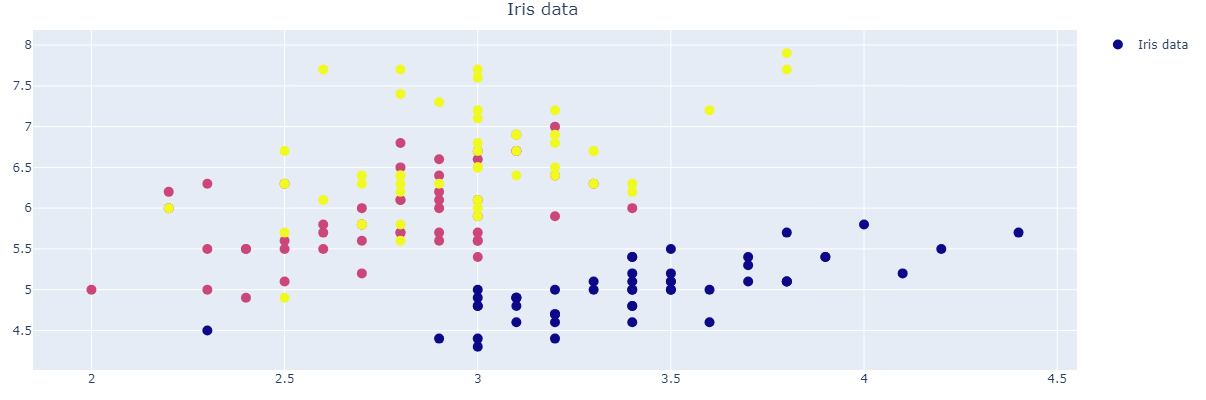

In [43]:
# 使用go.Scatter，点图需要指定参数 mode=markers，否则绘制的是线图
# fig = go.Figure(data=go.Scatter(x=x, y=y, mode='markers'))
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='Iris data',
        # mode 设置为 散点图
        mode='markers',
        x=iris_df['sepal_width'], y=iris_df['sepal_length'], 
        showlegend=True,
        # 用于控制点的形状，大小，颜色之类的属性，以字典的方式传入
        marker=dict(
            size=10,
            # color = list(df['species'])  # 离散的字符变量不能用作颜色，只能使用数值
            color = list(iris_df['species_id']),
        )
    )
)

fig.update_layout(
    title=dict(
        text = 'Iris data',
        x = 0.45
    ),
    autosize=False, width=600, height=400, 
    # 设置一下 页面白边
    margin=dict(l=30, r=30, t=30, b=30)
)

fig.show()

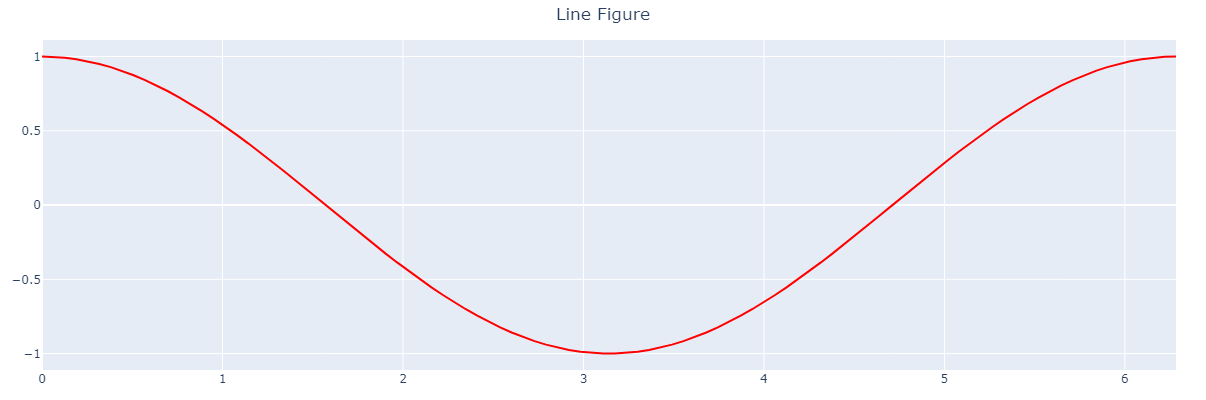

In [46]:
t = np.linspace(0, 2*np.pi, 100)

# 注意，也是使用的Scatter，但是不用指定 mode 参数，因此默认为线图
fig = go.Figure(
    data=go.Scatter(
        x=t, y=np.cos(t),
        mode="lines",
        line=dict(color="red")
    )
)
fig.update_layout(
    title=dict(text='Line Figure', x=0.5),
    autosize=False, width=600, height=400, 
    margin=dict(l=30, r=30, t=40, b=30)
)
fig.show()

### `express.scatter()`

px里用于绘制散点图的函数，参考文档有：
+ [API文档](https://plotly.com/python-api-reference/generated/plotly.express.scatter.html).
+ 教程文档 [Scatter plots with Plotly Express](https://plotly.com/python/line-and-scatter/#connected-scatterplots).

+ 使用自定义数据绘图

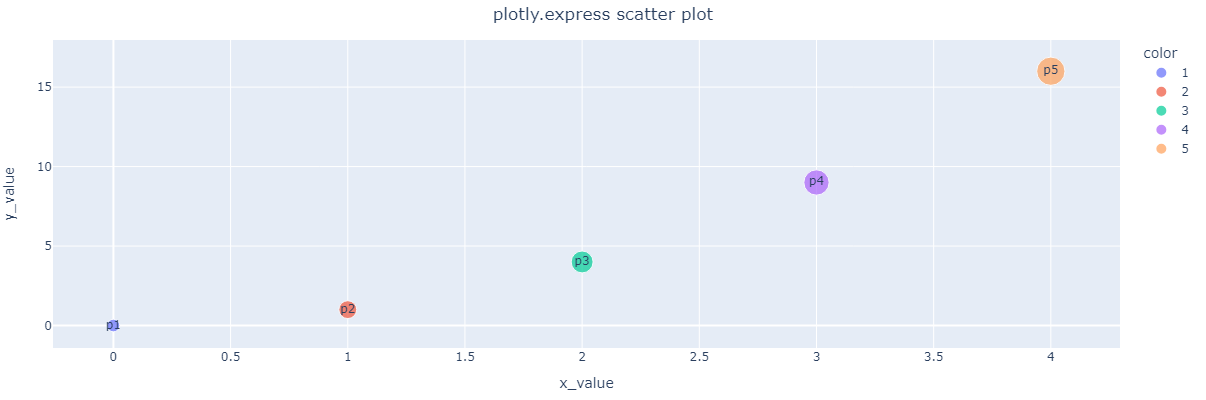

In [55]:
# 最简单的，x，y是list
# 但是这种情况下 color 和 size 必须提供对应的映射数据，不能是 str 或者 int
fig = px.scatter(
    title='plotly.express scatter plot',
    # width=600, height=400,
    x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16], 
    size=[1,2,3,4,5],
    # 颜色分别映射到 数值 和 字符 时的表现不一样（注意colorbar）
    # color=[1,2,3,4,5],
    color=['1','2','3','4','5'],
    # 显示在每个点上的文字
    text=['p1','p2','p3','p4','p5'],
    
    hover_name=['p1', 'p2', 'p3', 'p4', 'p5'],

    labels={'x': 'x_value', 'y':'y_value'},
)

fig.update_layout(
    title=dict(x=0.5),
    autosize=False, width=600, height=400, 
    margin=dict(l=30, r=30, t=40, b=30)
)
fig.show()

+ 使用dataframe绘图

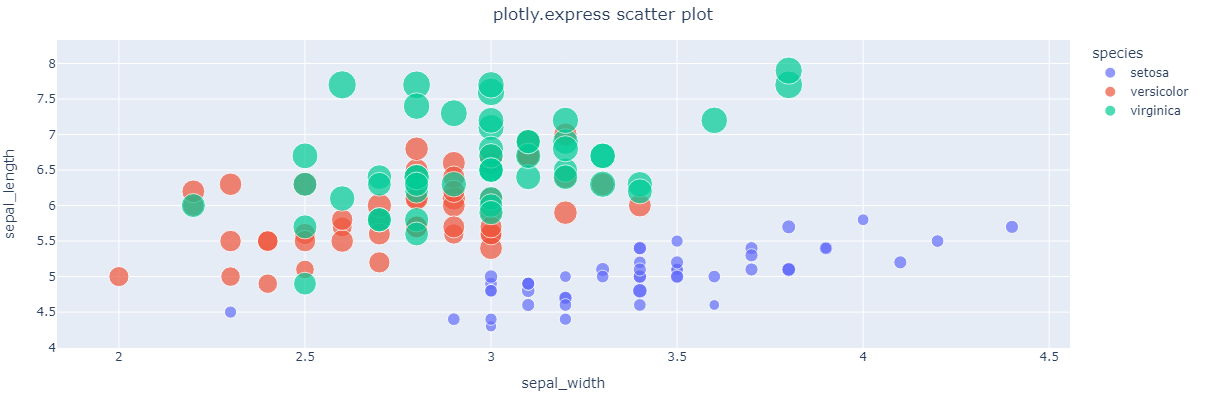

In [57]:
fig = px.scatter(
    data_frame=iris_df, 
    x='sepal_width', y='sepal_length', 
    color="species",
    size='petal_length', 
    hover_data=['petal_width']
)

fig.update_layout(
    title=dict(x=0.5, text='plotly.express scatter plot'),
    autosize=False, width=600, height=400, 
    margin=dict(l=30, r=30, t=40, b=30)
)

fig.show()

### `express.line()`

参考文档：
1. 教程文档 [Line Plots with plotly.express](https://plotly.com/python/line-charts/)
2. API文档 [plotly.express.line](https://plotly.com/python-api-reference/generated/plotly.express.line.html)

主要参数和`plotly.express.scatter`里的差不多，独有的参数如下：
+ `marker`，是否显示对应的点，默认为False.


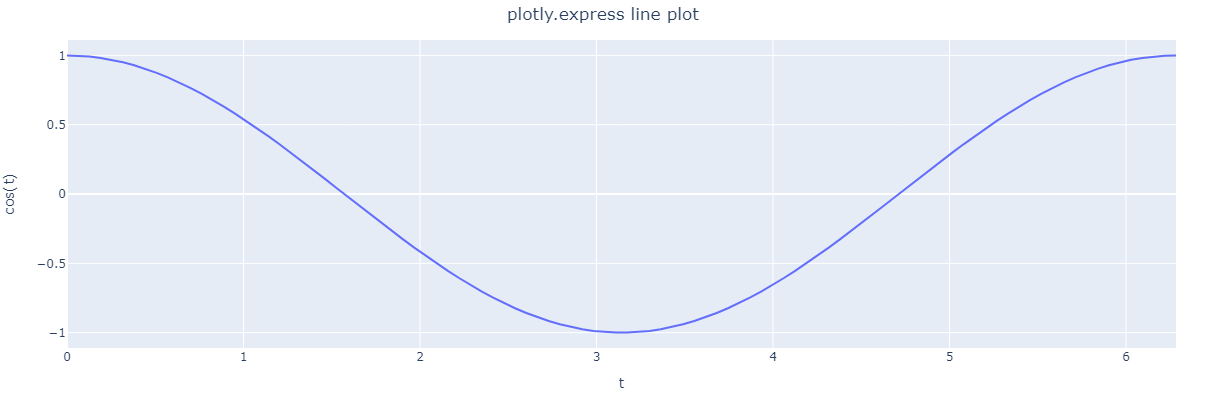

In [58]:
t = np.linspace(0, 2*np.pi, 100)

fig = px.line(x=t, y=np.cos(t), labels={'x':'t', 'y':'cos(t)'}, width=600, height=400)
fig.update_layout(
    title=dict(x=0.5, text='plotly.express line plot'),
    autosize=False, width=600, height=400, 
    margin=dict(l=30, r=30, t=40, b=30)
)
fig.show()

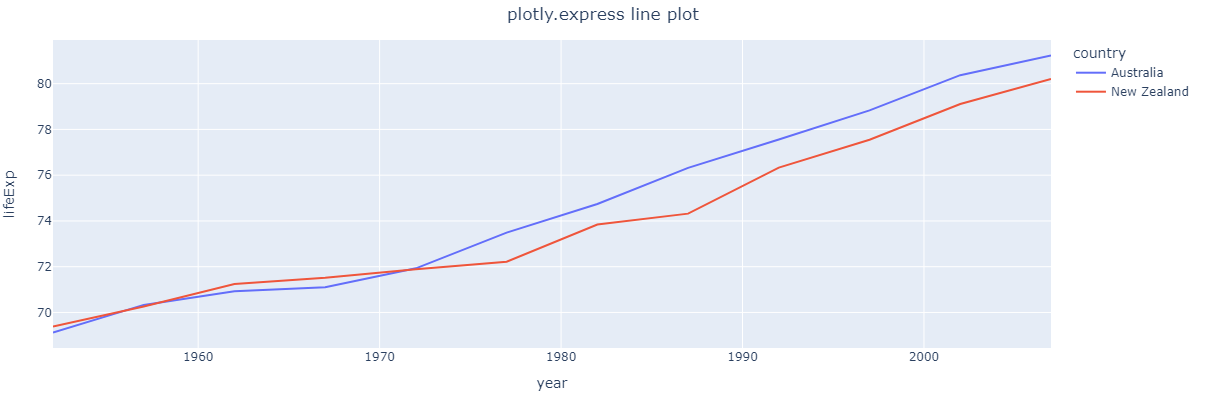

In [59]:
fig = px.line(gap_df, x='year', y='lifeExp', color='country', width=600, height=400)
fig.update_layout(
    title=dict(x=0.5, text='plotly.express line plot'),
    autosize=False, width=600, height=400, 
    margin=dict(l=30, r=30, t=40, b=30)
)
fig.show()

## 条形图

官方文档 [`bar` Traces](https://plotly.com/python/reference/bar/).

```python
fig.update_traces(
    name=''           // trace的名称，会被作为legend中的某一项显示
    visible=True,     // 是否可见
    showlegend=True,  // 是否在legend中显示此trace对应的图例项
    legendgroup='',
    opacity=0.5,      // 透明度，[0,1]
    
    x=[],             // x 坐标的值
    y=[],             // y 坐标的值
    ids=[],           // 序列，指定每个数据点的标签
    text='',          // 每个(x,y)数据点所关联的文本，会显示在对应点的上面
    textposition='top left',    // text的位置，可选：top left, top right, top center, middle left, bottom right 等
    customdata = [],            // 
    orientation = '',           // 绘图方向，可选 'v' 或者 'h'
    
    // 条形图独有的参数
    base=None,     //
    width=None,    // 条形图宽度
    offset=None,   // 条形图偏移量
    
    // 控制该子图的绘图坐标系 ------ KEY
    // 下面两个参数的值为str，但是这些str指定的是对应于Figure中的子图坐标系(subplotid)
    // 如果Figure有两个子图，对应于2个坐标系，这两个坐标系的坐标轴命名为 (xaxis, yaxis), (xaxis2, yaxis2)
    // 这里如果指定 (`x1`, `y1`)，就表示将当前Trace的坐标系为第2个.
    xaxis='x',
    yaxis='y',
    
    // 指定每个(x,y)点在鼠标悬浮时显示的文本
    hovertext = "",
    // 指定该trace有哪些内容显示在悬浮标签上. 取值为：'x', 'y', 'z', 'text', 'name' 以及它们的组合(使用 + 组合)
    hoverinfo = "",
    hovertemplate = "",
    
    // 控制点的属性，这个非常丰富
    marker=dict(
        color='',         // 颜色，可以是一个字符串，或者一个list，指定每个点的颜色
        opacity=0.5,      // 透明度
        size=6,           // 点的大小，默认6（单位：px）
        symbol='circle'   // 点的形状
    ),
    
    // 控制文字
    textfont=dict(
        color = "",    // 文字颜色
        size = 6,
        family = ""
    ),
    
    error_x = dict(),
    error_y = dict(),
    
    // 这里是更新条形图，需要选择Figure对象里的type=bar的trace
    selector=dict(type='bar')
)
```

### graph_object.Bar

[API文档](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Bar.html)，它的参数见上面。

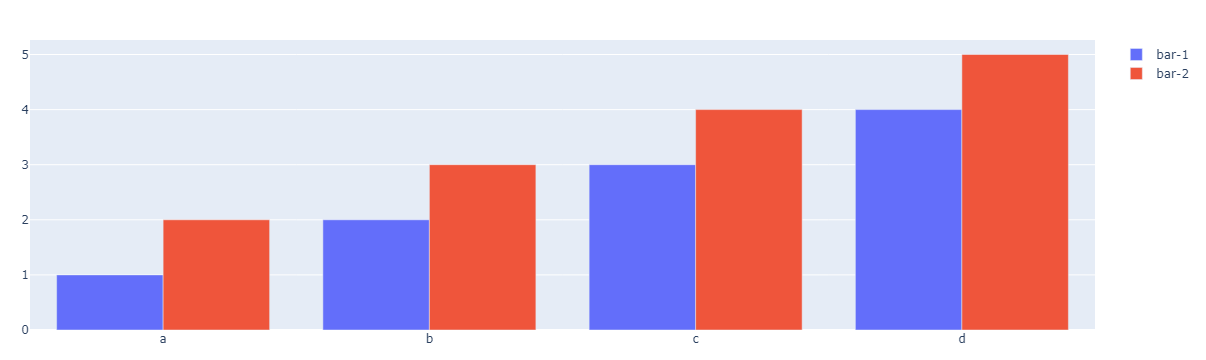

In [65]:
fig = go.Figure(
    # 这里放入了两个trace
    [
        go.Bar(
            name='bar-1',
            x=['a','b','c','d'],
            y=[1,2,3,4,5]
        ),
        go.Bar(
            name='bar-2',
            x=['a','b','c','d'],
            y=[2,3,4,5,6]
        )
    ]
)
fig.update_layout(
    # 控制堆叠条形图或者分组条形图
    # barmode='stack',
    barmode='group',
    # barmode='overlay',
    
    width=600, height=300, autosize=False,
    margin=dict(l=30, r=30, t=40, b=30)
)
fig.show()

### express.bar

参考文档:
+ 教程文档 [Bar chart with Plotly Express](https://plotly.com/python/bar-charts/).
+ API文档 [plotly.express.bar](https://plotly.com/python-api-reference/generated/plotly.express.bar.html).

主要参数：
+ `data_frame`
+ `x`: 指定条形图的类别变量
+ `y`: 指定条形图高度对应的数值——注意，这个数值必须要自己算出来，不像seaborn那样可以自己统计。

独有的参数如下：
+ `barmode`: 用于控制绘制的条形图类别：
  + `relative`，条形图高度有正负之分
  + `group`，分组条形图，注意，此时指定分组的`color`所对应的特征必须是分类变量，否则不会生效
  + `overlay`，堆叠条形图

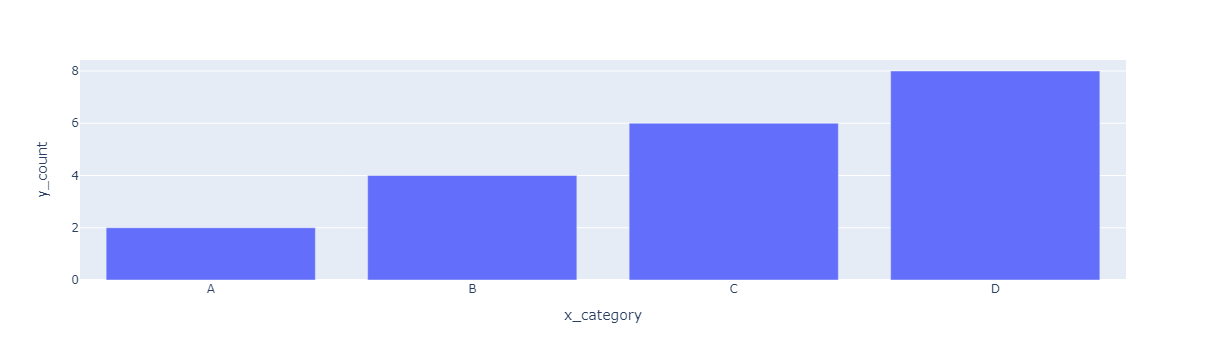

In [51]:
bar_data = pd.DataFrame({'x_category': ['A','B','C','D'], 'y_count': [2,4,6,8]})
fig = px.bar(bar_data, x='x_category', y='y_count', width=600, height=350)
fig.show()

+ 对于long-format和wide-format的数据，可以绘制分组条形图

In [52]:
long_df = px.data.medals_long()
long_df.head()

nation   medal  count
0  South Korea    gold     24
1        China    gold     10
2       Canada    gold      9
3  South Korea  silver     13
4        China  silver     15

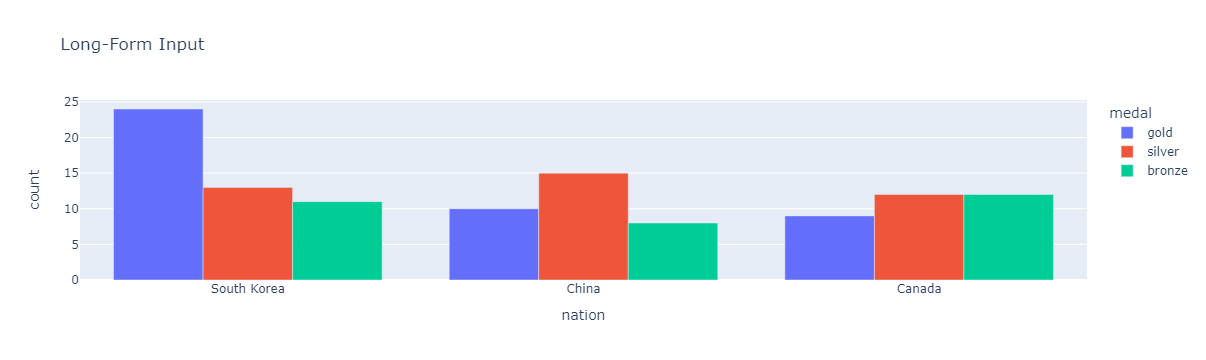

In [53]:
# 分组条形图
fig = px.bar(long_df, x="nation", y="count", color="medal", title="Long-Form Input", barmode='group')
# 堆叠条形图
# fig = px.bar(long_df, x="nation", y="count", color="medal", title="Long-Form Input", barmode='overlay')
fig.show()

In [54]:
wide_df = px.data.medals_wide()
wide_df.head()

nation  gold  silver  bronze
0  South Korea    24      13      11
1        China    10      15       8
2       Canada     9      12      12

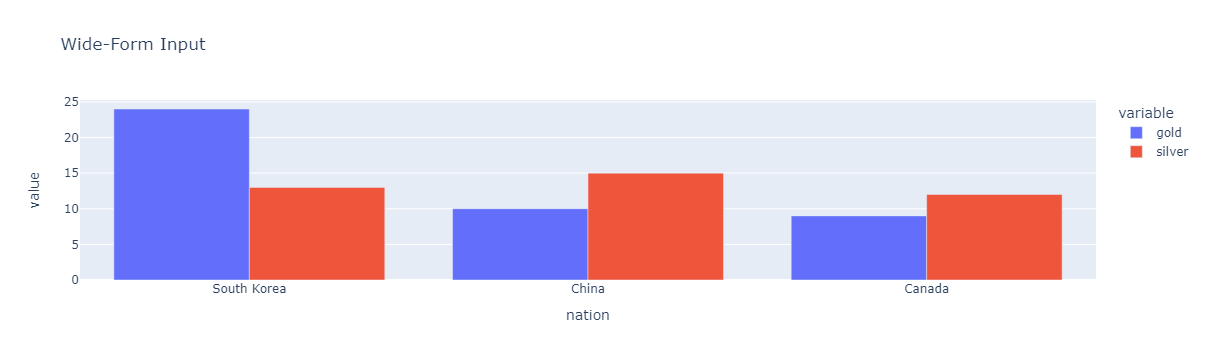

In [55]:
# 需要选择展示哪些列
# fig = px.bar(wide_df, x="nation", y=["gold", "silver", "bronze"], title="Wide-Form Input")
fig = px.bar(wide_df, x="nation", y=["gold", "silver"], title="Wide-Form Input", barmode='group')
# fig = px.bar(wide_df, x="nation", y=["gold", "silver"], title="Wide-Form Input", barmode='overlay')
fig.show()

## 直方图

官方文档 [`histogram` Traces](https://plotly.com/python/reference/histogram/).

```python
fig.update_traces(
    name=''           // trace的名称，会被作为legend中的某一项显示
    visible=True,     // 是否可见
    showlegend=True,  // 是否在legend中显示此trace对应的图例项
    legendgroup='',
    opacity=0.5,      // 透明度，[0,1]
    
    x=[],             // x 坐标的值
    y=[],             // y 坐标的值
    ids=[],           // 序列，指定每个数据点的标签
    text='',          // 每个(x,y)数据点所关联的文本，会显示在对应点的上面
    textposition='top left',    // text的位置，可选：top left, top right, top center, middle left, bottom right 等
    customdata = [],            // 
    orientation = '',           // 绘图方向，可选 'v' 或者 'h'
    
    // 直方图独有的参数
    histfun='count',     // 控制绘制频率还是频数直方图，取值: 'count', 'sum', 'avg', 'min', 'max'
    histnorm='',         // 直方图的归一化方式，取值：'percent', 'probability', 'density', 'probability density'
    nbinsx=0, nbinsy=0,  // 指定x或者y轴上最大的区间数
    autobinx=True,autobiny=True,  // 自动确定分割区间
    xbins=dict(),ybins=dict(),    // 指定分割区间
    
    // 控制该子图的绘图坐标系 ------ KEY
    // 下面两个参数的值为str，但是这些str指定的是对应于Figure中的子图坐标系(subplotid)
    // 如果Figure有两个子图，对应于2个坐标系，这两个坐标系的坐标轴命名为 (xaxis, yaxis), (xaxis2, yaxis2)
    // 这里如果指定 (`x1`, `y1`)，就表示将当前Trace的坐标系为第2个.
    xaxis='x',
    yaxis='y',
    
    // 指定每个(x,y)点在鼠标悬浮时显示的文本
    hovertext = "",
    // 指定该trace有哪些内容显示在悬浮标签上. 取值为：'x', 'y', 'z', 'text', 'name' 以及它们的组合(使用 + 组合)
    hoverinfo = "",
    hovertemplate = "",
    
    // 控制点的属性，这个非常丰富
    marker=dict(
        color='',         // 颜色，可以是一个字符串，或者一个list，指定每个点的颜色
        opacity=0.5,      // 透明度
        size=6,           // 点的大小，默认6（单位：px）
        symbol='circle'   // 点的形状
    ),
    
    // 控制文字
    textfont=dict(
        color = "",    // 文字颜色
        size = 6,
        family = ""
    ),
    
    error_x = dict(),
    error_y = dict(),

    selector=dict(type='histogram')
)
```

### graph_object.Histogram

[API文档](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Histogram.html#plotly.graph_objects.Histogram).

这个API在绘制直方图的时候，只需要提供`x`或者`y`中一个的取值就行了。   
+ `x`用于绘制竖直直方图，`y`用于绘制水平直方图。
+ `xbins`或`ybins`分别用于控制区间数。

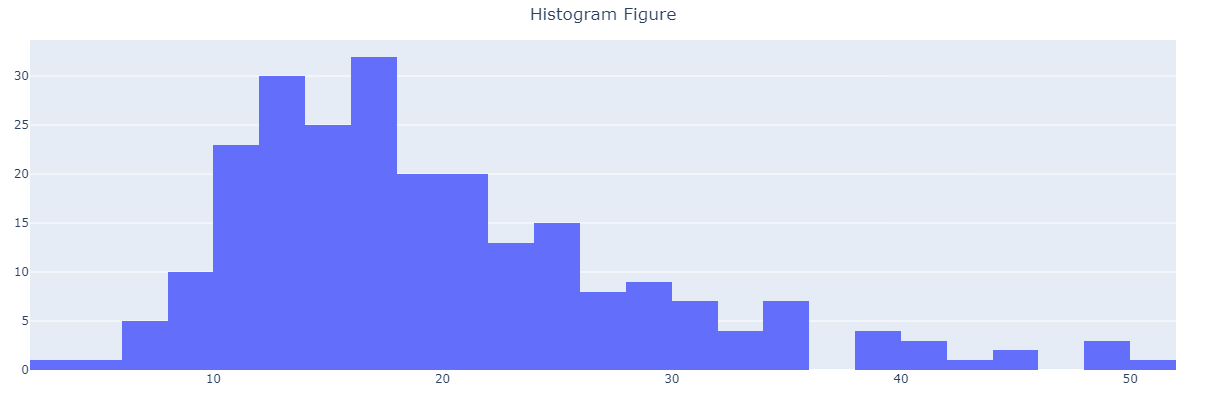

In [68]:
fig = go.Figure(
    go.Histogram(
        x=tips_df['total_bill']
    )
)
fig.update_layout(
    title=dict(x=0.5, text='Histogram Figure'),
    autosize=False, width=600, height=400, 
    margin=dict(l=30, r=30, t=40, b=30),
    showlegend=False
)

fig.show()

### express.histogram

参考文档:
+ 教程文档 [Histograms with Plotly Express](https://plotly.com/python/histograms/).
+ API文档 [plotly.express.histogram](https://plotly.com/python-api-reference/generated/plotly.express.histogram.html).

独有的参数：
+ `barmode`
+ `barnorm`
+ `histnorm`，可选`percent`, `probability`, `density`
+ `histfunc`，聚合的函数，可选`count`, `sum`, `avg`, `min`, `max`
+ `cumulative`，是否为累积直方图，默认False
+ `nbins`，设定直方图的bin数目

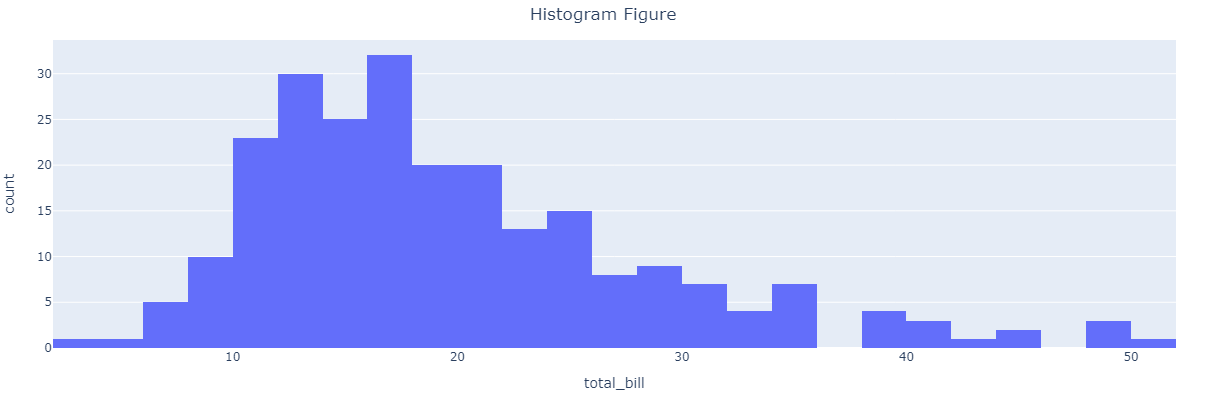

In [69]:
fig = px.histogram(tips_df, x="total_bill")
fig.update_layout(
    title=dict(x=0.5, text='Histogram Figure'),
    autosize=False, width=600, height=400, 
    margin=dict(l=30, r=30, t=40, b=30),
    showlegend=False
)
fig.show()

## 箱线图

官方文档 [`box` Traces](https://plotly.com/python/reference/box/).

```python
fig.update_traces(
    name=''           // trace的名称，会被作为legend中的某一项显示
    visible=True,     // 是否可见
    showlegend=True,  // 是否在legend中显示此trace对应的图例项
    legendgroup='',
    opacity=0.5,      // 透明度，[0,1]
    
    x=[],             // x 坐标的值
    y=[],             // y 坐标的值
    ids=[],           // 序列，指定每个数据点的标签
    text='',          // 每个(x,y)数据点所关联的文本，会显示在对应点的上面
    textposition='top left',    // text的位置，可选：top left, top right, top center, middle left, bottom right 等
    customdata = [],            // 
    orientation = '',           // 绘图方向，可选 'v' 或者 'h'
    
    // 箱线图独有的参数
    boxmean=True,      // 是否绘制均值线
    boxpoints='',      // 显示的点的范围，取值：'all', 'outliers', 'suspectedoutliers', False
    notched=False,     // 
    whiskerwidth=0.5,
    q1=[],
    median=[],
    mean=[],           // 每个箱线图的均值
    sd=[]
    q3=[],
    lowerfence=[],upperfenct=[],   // 每个箱线图的上下界
    quantilemethod='',  // 分位数计算方式，取值：linear, exclusive, inclusive
    
    // 控制该子图的绘图坐标系 ------ KEY
    // 下面两个参数的值为str，但是这些str指定的是对应于Figure中的子图坐标系(subplotid)
    // 如果Figure有两个子图，对应于2个坐标系，这两个坐标系的坐标轴命名为 (xaxis, yaxis), (xaxis2, yaxis2)
    // 这里如果指定 (`x1`, `y1`)，就表示将当前Trace的坐标系为第2个.
    xaxis='x',
    yaxis='y',
    
    // 指定每个(x,y)点在鼠标悬浮时显示的文本
    hovertext = "",
    // 指定该trace有哪些内容显示在悬浮标签上. 取值为：'x', 'y', 'z', 'text', 'name' 以及它们的组合(使用 + 组合)
    hoverinfo = "",
    hovertemplate = "",
    
    // 控制点的属性，这个非常丰富
    marker=dict(
        color='',         // 颜色，可以是一个字符串，或者一个list，指定每个点的颜色
        opacity=0.5,      // 透明度
        size=6,           // 点的大小，默认6（单位：px）
        symbol='circle'   // 点的形状
    ),
    
    // 控制文字
    textfont=dict(
        color = "",    // 文字颜色
        size = 6,
        family = ""
    ),
    
    error_x = dict(),
    error_y = dict(),

    selector=dict(type='box')
)
```

### graph_object.Box

[API文档](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Box.html#plotly.graph_objects.Box)，详细参数见上面。

这个API有两个函数签名：
1. 提供了`y`, `x`的值.   
如果提供了`x`，`x`被用于对`y`进行分组，**长度必须和`y`相等**，`x`的每个取值都会画一个箱线图，箱线图的取值从`y`的数组计算；没有提供`x`，则只绘制一个箱线图。  
如果`x`, `y`的角色对调，此时使用`orientatino='h'`参数，就是**绘制水平的箱线图**。
2. 提供`q1`, `median`, `q3` 等每个箱线图统计之后的值，直接用这些值绘图。

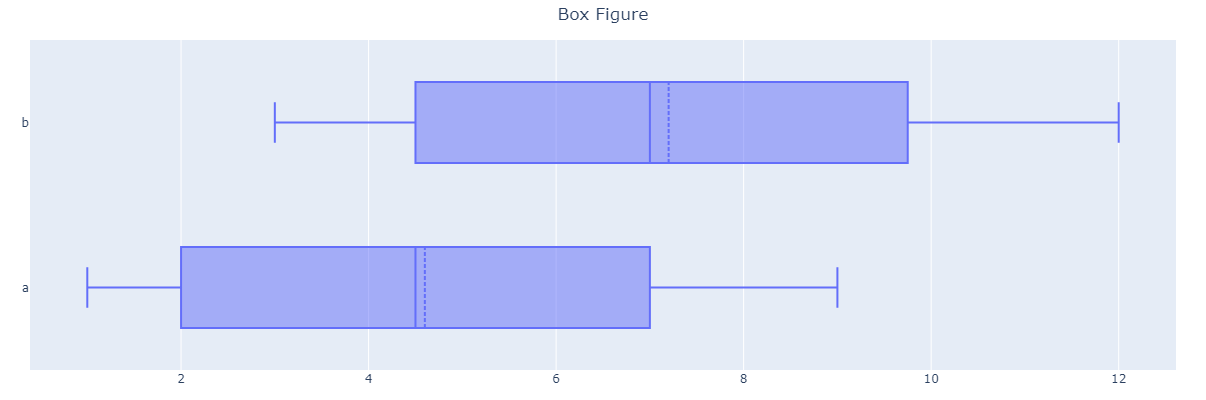

In [70]:
fig = go.Figure(
    # 只提供 y 
    # go.Box(
    #     name='trace-1',
    #     y=[1,2,3,4,5,6,7,8,9]
    # )
    # 提供 x 和 y
    # go.Box(
    #     name='trace-1',
    #     x=['a']*10 + ['b']*6,
    #     y=[1,2,3,4,5,6,7,8,9, 1,3,5,7,9,12]
    # )
    # 对调 x,y 的位置，绘制水平箱线图
    go.Box(
        name='trace-1',
        y=['a']*10 + ['b']*6,
        x=[1,2,3,4,5,6,7,8,9, 1,3,5,7,9,12],
        orientation='h',
        boxmean=True,
        # notched=True
    )
)

fig.update_layout(
    title=dict(x=0.5, text='Box Figure'),
    autosize=False, width=600, height=400, 
    margin=dict(l=30, r=30, t=40, b=30),
    showlegend=False
)

fig.show()

### express.box

参考文档:
+ 教程文档 [Box with Plotly Express](https://plotly.com/python/box-plots/).
+ API文档 [plotly.express.box](https://plotly.com/python-api-reference/generated/plotly.express.box.html).
+ [Plotly: How to group data and specify colors using go.box instead of px.box?
](https://stackoverflow.com/questions/60588385/plotly-how-to-group-data-and-specify-colors-using-go-box-instead-of-px-box)

独有的参数：
+ `boxmode`：箱线图的模式，取值：`grouop`, `overlay`
+ `points`：显示的点的范围，取值：`outliers`, `all`, `suspectedoutliers`
+ `notched`，是否显示刘海，默认`False`

注意，使用`px`就**没办法控制是否绘制均值线等细节了**！！

In [81]:
tips_df.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

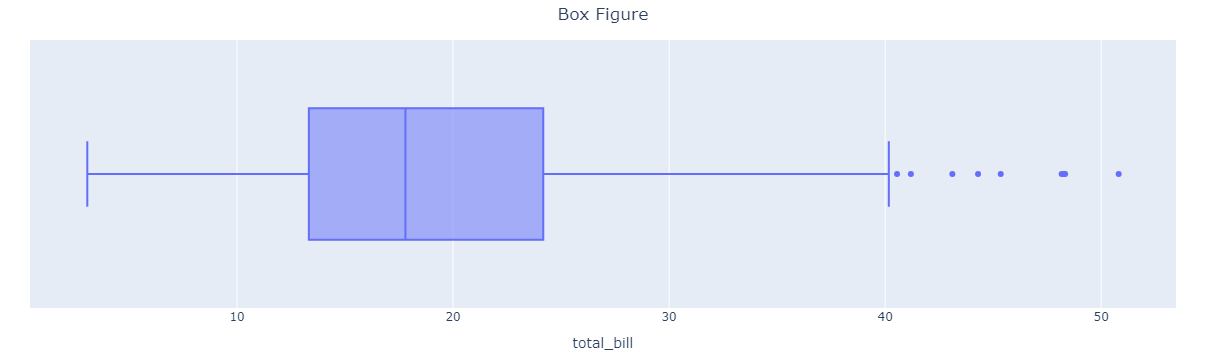

In [71]:
# fig = px.box(tips_df, y="total_bill", orientation='v')
fig = px.box(tips_df, x="total_bill", orientation='h')
fig.update_layout(
    title=dict(x=0.5, text='Box Figure'),
    autosize=False, width=600, height=300, 
    margin=dict(l=30, r=30, t=40, b=30),
    showlegend=False
)
fig.show()

## 小提琴图

官方文档 [`violin` Traces](https://plotly.com/python/reference/violin/).

```python
fig.update_traces(
    name=''           // trace的名称，会被作为legend中的某一项显示
    visible=True,     // 是否可见
    showlegend=True,  // 是否在legend中显示此trace对应的图例项
    legendgroup='',
    opacity=0.5,      // 透明度，[0,1]
    
    x=[],             // x 坐标的值
    y=[],             // y 坐标的值
    ids=[],           // 序列，指定每个数据点的标签
    text='',          // 每个(x,y)数据点所关联的文本，会显示在对应点的上面
    textposition='top left',    // text的位置，可选：top left, top right, top center, middle left, bottom right 等
    customdata = [],            // 
    orientation = '',           // 绘图方向，可选 'v' 或者 'h'
    
    // 箱线图独有的参数
    bandwidth=1,
    box=dict(),
    points=False,            // 显示点的范围，取值：'all', 'outliers', 'suspectedoutliers`, False
    scalegroup='',
    scalemode='width',
    side='both',
    span='',
    spanmode='',
    stream='',
    
    
    // 控制该子图的绘图坐标系 ------ KEY
    // 下面两个参数的值为str，但是这些str指定的是对应于Figure中的子图坐标系(subplotid)
    // 如果Figure有两个子图，对应于2个坐标系，这两个坐标系的坐标轴命名为 (xaxis, yaxis), (xaxis2, yaxis2)
    // 这里如果指定 (`x1`, `y1`)，就表示将当前Trace的坐标系为第2个.
    xaxis='x',
    yaxis='y',
    
    // 指定每个(x,y)点在鼠标悬浮时显示的文本
    hovertext = "",
    // 指定该trace有哪些内容显示在悬浮标签上. 取值为：'x', 'y', 'z', 'text', 'name' 以及它们的组合(使用 + 组合)
    hoverinfo = "",
    hovertemplate = "",
    
    // 控制点的属性，这个非常丰富
    marker=dict(
        color='',         // 颜色，可以是一个字符串，或者一个list，指定每个点的颜色
        opacity=0.5,      // 透明度
        size=6,           // 点的大小，默认6（单位：px）
        symbol='circle'   // 点的形状
    ),
    
    // 控制文字
    textfont=dict(
        color = "",    // 文字颜色
        size = 6,
        family = ""
    ),
    
    error_x = dict(),
    error_y = dict(),

    selector=dict(type='violin')
)
```

### graph_object.Violin

[API文档](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Violin.html#plotly.graph_objects.Violin).

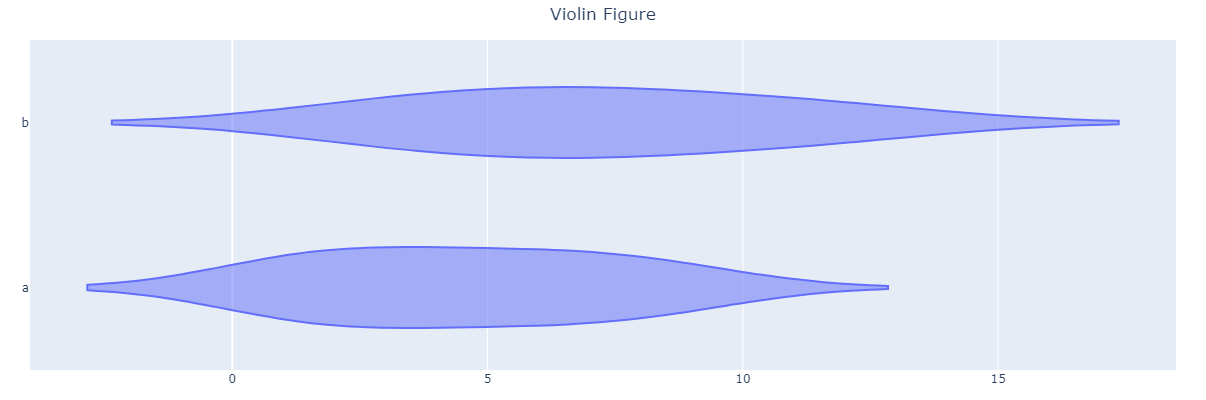

In [73]:
fig = go.Figure(
    go.Violin(
        name='trace-1',
        y=['a']*10 + ['b']*6,
        x=[1,2,3,4,5,6,7,8,9, 1,3,5,7,9,12],
        orientation='h',
        points='outliers'
    )
)

fig.update_layout(
    title=dict(x=0.5, text='Violin Figure'),
    autosize=False, width=800, height=400, 
    margin=dict(l=30, r=30, t=40, b=30),
    showlegend=False
)

fig.show()

### express.violin

参考文档:
+ 教程文档 [Violin Plot with Plotly Express](https://plotly.com/python/violin/).
+ API文档 [plotly.express.violin](https://plotly.com/python-api-reference/generated/plotly.express.violin.html).

独有的参数：
+ `violinmode`, 取值为：`group`, `overlay`, 
+ `points`

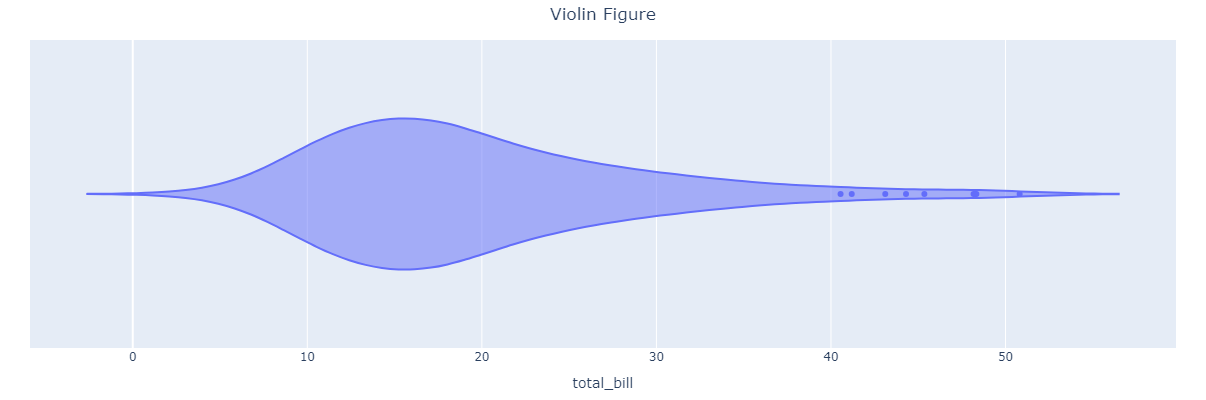

In [74]:
# 纵向，total_bill 为 X 轴
# fig = px.violin(tips_df, x="total_bill", orientation='h')
# 横向，total_bill 为 Y  轴
fig = px.violin(tips_df, x="total_bill", orientation='h')

fig.update_layout(
    title=dict(x=0.5, text='Violin Figure'),
    autosize=False, width=800, height=400, 
    margin=dict(l=30, r=30, t=40, b=30),
    showlegend=False
)

fig.show()

## 饼图

官方文档 [`pie` Traces](https://plotly.com/python/reference/pie/).

### graph_object.Pie

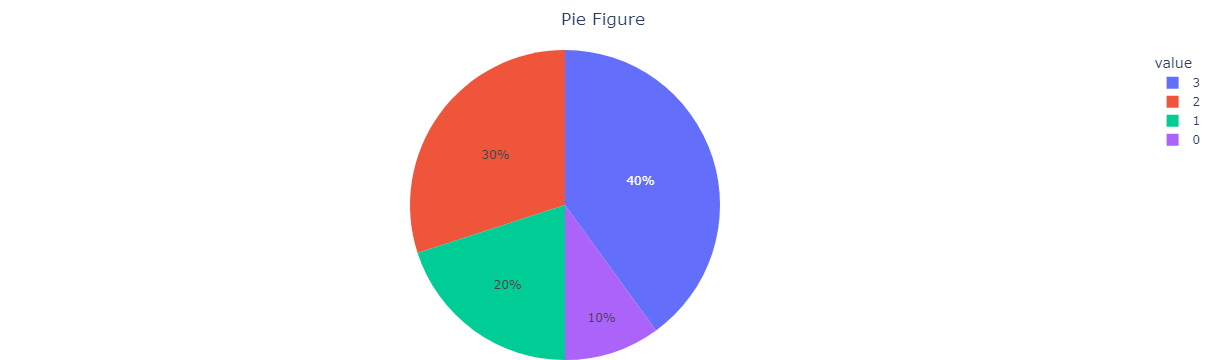

In [75]:
fig = go.Figure(
    go.Pie(
        values=[1,2,3,4]
    )
)

fig.update_layout(
    title=dict(text='Pie Figure', x=0.5),
    autosize=False, width=500, height=300,
    showlegend=True,
    legend_title=dict(text='value'),
    margin=dict(t=50, l=0, r=0, b=0)
)

fig.show(width=200, height=200)

### express.pie

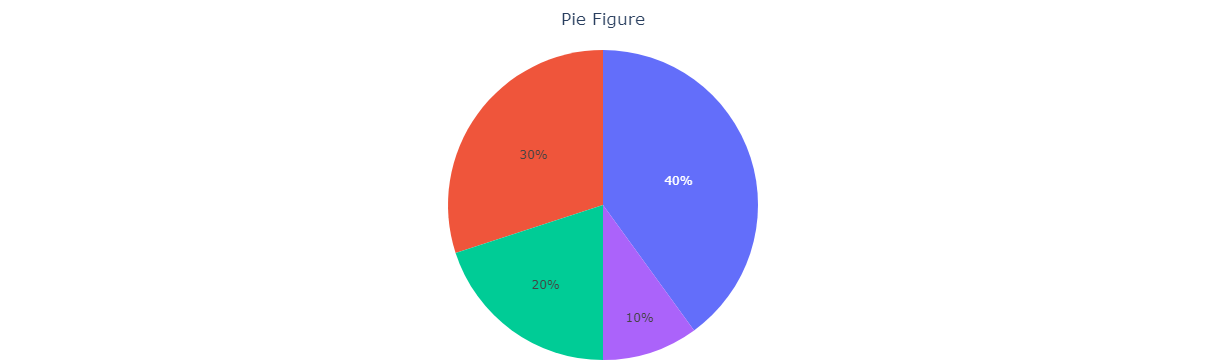

In [76]:
fig = px.pie(values=[1,2,3,4])
fig.update_layout(
    title=dict(text='Pie Figure', x=0.5),
    autosize=False, width=500, height=300,
    showlegend=True,
    legend_title=dict(text='value'),
    margin=dict(t=50, l=0, r=0, b=0)
)
fig.show()

## 热力图

### graph_object.Heatmap

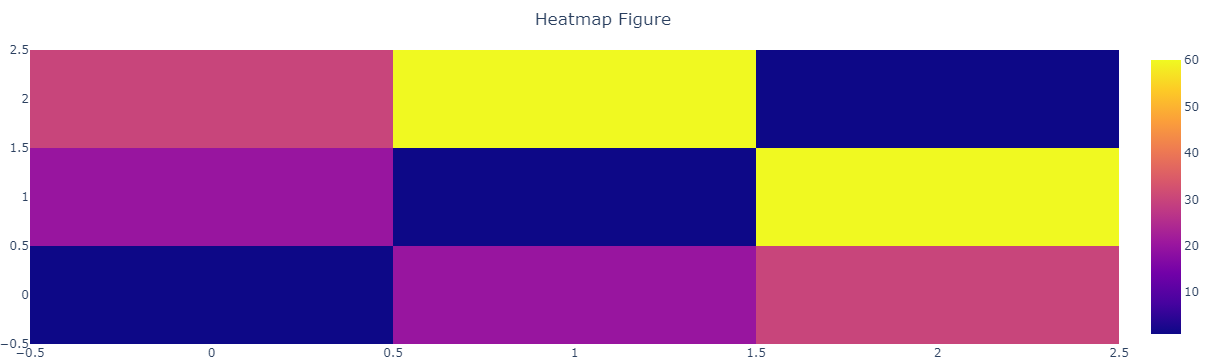

In [77]:
fig = go.Figure(
    data=go.Heatmap(
        z=[[1, 20, 30], [20, 1, 60], [30, 60, 1]]
    )
)

fig.update_layout(
    title=dict(text='Heatmap Figure', x=0.5),
    autosize=False, width=500, height=300,
    showlegend=True,
    legend_title=dict(text='value'),
    margin=dict(t=50, l=0, r=0, b=0)
)

fig.show()

### express.imshow

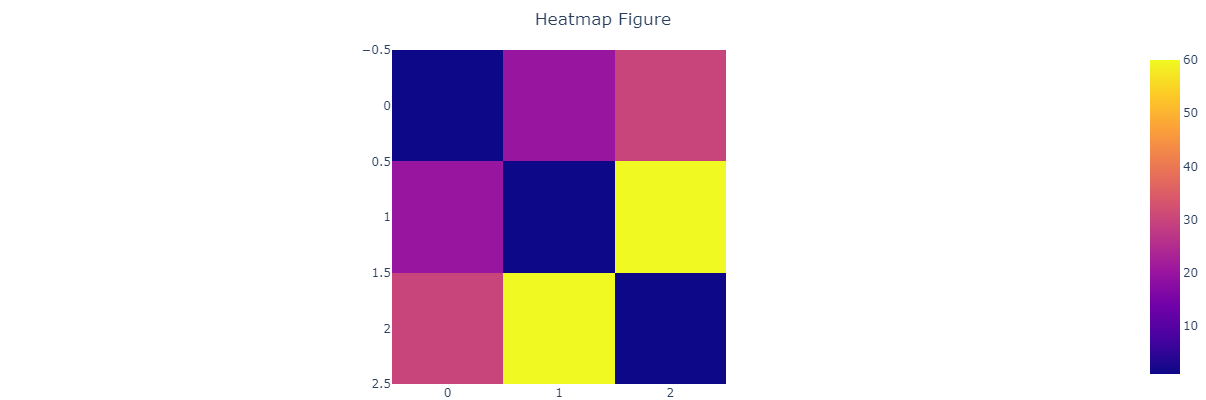

In [81]:
fig = px.imshow(
    [[1, 20, 30], [20, 1, 60], [30, 60, 1]]
)
fig.update_layout(
    title=dict(text='Heatmap Figure', x=0.5),
    autosize=False, width=600, height=400,
    showlegend=True,
    legend_title=dict(text='value'),
    margin=dict(t=50, l=0, r=0, b=0)
)
fig.show()

## 旭日图

旭日图(SunBurst plot)

In [83]:
data = pd.DataFrame({
    'character': ["Eve", "Cain", "Seth", "Enos", "Noam", "Abel", "Awan", "Enoch", "Azura"],
    'parent': ["", "Eve", "Eve", "Seth", "Seth", "Eve", "Eve", "Awan", "Eve" ],
    'value': [10, 14, 12, 10, 2, 6, 6, 4, 4]
})
data.head()

character parent  value
0       Eve            10
1      Cain    Eve     14
2      Seth    Eve     12
3      Enos   Seth     10
4      Noam   Seth      2

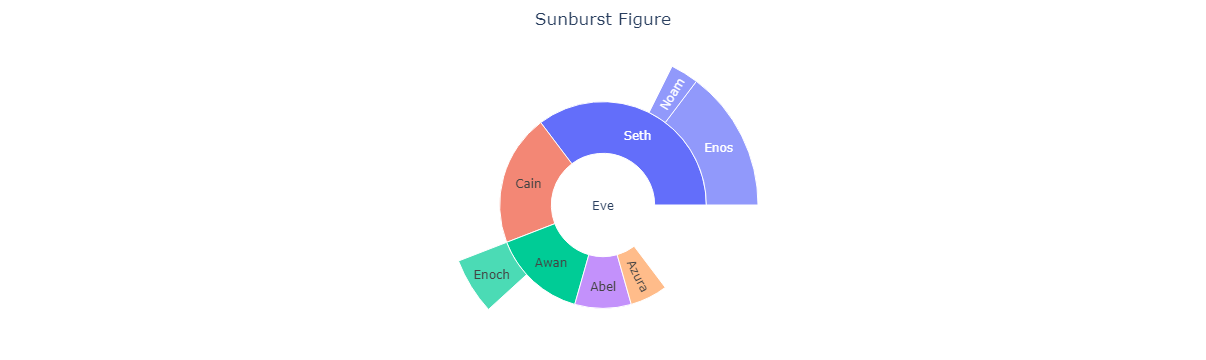

In [84]:
fig = px.sunburst(data, names='character', parents='parent', values='value', width=600, height=400)

fig.update_layout(
    title=dict(text='Sunburst Figure', x=0.5),
    autosize=False, width=500, height=300,
    showlegend=True,
    legend_title=dict(text='value'),
    margin=dict(t=50, l=0, r=0, b=0)
)

fig.show()

In [21]:
print(fig)

Figure({
    'data': [{'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
              'hovertemplate': 'character=%{label}<br>value=%{value}<br>parent=%{parent}<extra></extra>',
              'labels': array(['Eve', 'Cain', 'Seth', 'Enos', 'Noam', 'Abel', 'Awan', 'Enoch', 'Azura'],
                              dtype=object),
              'name': '',
              'parents': array(['', 'Eve', 'Eve', 'Seth', 'Seth', 'Eve', 'Eve', 'Awan', 'Eve'],
                               dtype=object),
              'type': 'sunburst',
              'values': array([10, 14, 12, 10,  2,  6,  6,  4,  4], dtype=int64)}],
    'layout': {'height': 400, 'legend': {'tracegroupgap': 0}, 'margin': {'t': 60}, 'template': '...', 'width': 600}
})


-----

# 色彩控制

+ 连续色彩参考官方文档：
  + [Continuous Color Scales and Color Bars in Python](https://plotly.com/python/colorscales/)
  + [Built-in Continuous Color Scales in Python](https://plotly.com/python/builtin-colorscales/).


+ 离散色彩参考官方文档
  + [Discrete Colors in Python](https://plotly.com/python/discrete-color/#discrete-vs-continuous-color).

----

# 绘图示例

## 机器学习相关

参考官方文档 [Plotly Python Open Source Graphing Library Artificial Intelligence and Machine Learning Charts](https://plotly.com/python/ai-ml/).

### 线性回归可视化
参考文档:
+ [ML Regression in Python](https://plotly.com/python/ml-regression/)

### ROC曲线可视化

参考文档：
+ [ROC and PR Curves in Python](https://plotly.com/python/roc-and-pr-curves/)


### PCA可视化
参考文档：
+ [PCA Visualization in Python](https://plotly.com/python/pca-visualization/)